In [0]:
# %pip install synapseml
# dbutils.library.restartPython()

In [0]:
# Install CatBoost using pip
# Best practice: Use %pip to install packages in Databricks notebooks to ensure the environment is updated.
# %pip install catboost

In [0]:
# Use Spark DataFrame for large data exploration
# This will load the complete table as a Spark DataFrame (distributed, scalable)
df_raw = spark.table("dl_tenants_daas.us_wealth_management.wealth_management_client_metrics")

from pyspark.sql.functions import concat_ws

# Remove duplicate policy_no for each cont_id
df_raw = df_raw.dropDuplicates(["cont_id", "policy_no"])

# Show schema and first few rows
# df_raw.printSchema()
# display(df_raw)

In [0]:
# # Use Spark DataFrame for large data exploration
# # This will load the filtered table as a Spark DataFrame (distributed, scalable)
# from pyspark.sql import functions as F

# # Find the most recent business_month
# recent_month = spark.table("dl_tenants_daas.us_wealth_management.wealth_management_client_metrics") \
#     .agg(F.max("business_month").alias("recent_month")).collect()[0]["recent_month"]

# # display(recent_month)

# df_raw = spark.table("dl_tenants_daas.us_wealth_management.wealth_management_client_metrics") \
#     .filter((F.col("branchoffice_code") == "83") & (F.col("business_month") == recent_month))

# # # Show schema and first few rows
# # df_raw.printSchema()
# # display(df_raw)

In [0]:
from pyspark.sql import functions as F, Window
from pyspark.sql.types import StructType, StructField, StringType, IntegerType
import pandas as pd
import lightgbm as lgb
from sklearn.metrics import f1_score, accuracy_score, classification_report, confusion_matrix

# ------------- PARAMETERS -------------
SAMPLE_FRACTION = 0.6   # set None to use full data
TRAIN_FRAC = 0.8
VAL_FRAC = 0.1
TEST_FRAC = 0.1
RANDOM_SEED = 42

# LightGBM training params
LGB_PARAMS = {
    "objective": "multiclass",
    "num_class": 6,               # will be set dynamically
    "metric": "multi_logloss",
    "boosting_type": "gbdt",
    "learning_rate": 0.05,
    "num_leaves": 64,
    "min_data_in_leaf": 50,
    "feature_fraction": 0.8,
    "subsample": 0.8,
    "subsample_freq": 1,
    "lambda_l2": 2.0,
    "verbosity": -1
}
NUM_BOOST_ROUND = 2000
EARLY_STOP = 50

# ------------- 1) Create product_category -------------
df_raw = df_raw.withColumn(
    "product_category",
    F.when(F.col("prod_lob") == "LIFE", "LIFE_INSURANCE")
    .when(F.col("sub_product_level_1").isin("VLI", "WL", "UL/IUL", "TERM", "PROTECTIVE PRODUCT"), "LIFE_INSURANCE")
    .when(F.col("sub_product_level_2").like("%LIFE%"), "LIFE_INSURANCE")
    .when(F.col("sub_product_level_2").isin(
        "VARIABLE UNIVERSAL LIFE", "WHOLE LIFE", "UNIVERSAL LIFE",
        "INDEX UNIVERSAL LIFE", "TERM PRODUCT", "VARIABLE LIFE",
        "SURVIVORSHIP WHOLE LIFE", "MONY PROTECTIVE PRODUCT"
    ), "LIFE_INSURANCE")
    .when(F.col("prod_lob").isin("GROUP RETIREMENT", "INDIVIDUAL RETIREMENT"), "RETIREMENT")
    .when(F.col("sub_product_level_1").isin(
        "EQUIVEST", "RETIREMENT 401K", "ACCUMULATOR",
        "RETIREMENT CORNERSTONE", "SCS", "INVESTMENT EDGE"
    ), "RETIREMENT")
    .when(
        (F.col("sub_product_level_2").like("%403B%")) |
        (F.col("sub_product_level_2").like("%401%")) |
        (F.col("sub_product_level_2").like("%IRA%")) |
        (F.col("sub_product_level_2").like("%SEP%")),
        "RETIREMENT"
    )
    .when(F.col("prod_lob") == "BROKER DEALER", "INVESTMENT")
    .when(F.col("sub_product_level_1").isin(
        "INVESTMENT PRODUCT - DIRECT", "INVESTMENT PRODUCT - BROKERAGE",
        "INVESTMENT PRODUCT - ADVISORY", "DIRECT", "BROKERAGE",
        "ADVISORY", "CASH SOLICITOR"
    ), "INVESTMENT")
    .when(
        (F.col("sub_product_level_2").like("%Investment%")) |
        (F.col("sub_product_level_2").like("%Brokerage%")) |
        (F.col("sub_product_level_2").like("%Advisory%")),
        "INVESTMENT"
    )
    .when(F.col("prod_lob") == "NETWORK", "NETWORK_PRODUCTS")
    .when(
        (F.col("sub_product_level_1") == "NETWORK PRODUCTS") |
        (F.col("sub_product_level_2") == "NETWORK PRODUCTS"),
        "NETWORK_PRODUCTS"
    )
    .when(
        (F.col("prod_lob") == "OTHERS") & (F.col("sub_product_level_1") == "HAS"),
        "DISABILITY"
    )
    .when(F.col("sub_product_level_2") == "HAS - DISABILITY", "DISABILITY")
    .when(F.col("prod_lob") == "OTHERS", "HEALTH")
    .when(F.col("sub_product_level_2") == "GROUP HEALTH PRODUCTS", "HEALTH")
    .otherwise("OTHER")
)

# ------------- 2) Filter and prepare events -------------
df_events = df_raw.select(
    "cont_id", "product_category", "register_date", "isrd_brth_date",
    "acct_val_amt", "face_amt", "cash_val_amt", "wc_total_assets",
    "wc_assetmix_stocks", "wc_assetmix_bonds", "wc_assetmix_mutual_funds",
    "wc_assetmix_annuity", "wc_assetmix_deposits", "wc_assetmix_other_assets",
    "psn_age", "client_seg", "client_seg_1", "aum_band", "channel", "agent_segment",
    "branchoffice_code", "policy_status"
).filter(
    (F.col("cont_id").isNotNull()) &
    (F.col("register_date").isNotNull()) &
    (F.col("product_category").isNotNull()) &
    (F.col("policy_status") == "Active")
)

if SAMPLE_FRACTION is not None:
    print("Sampling fraction:", SAMPLE_FRACTION)
    df_events = df_events.sample(withReplacement=False, fraction=float(SAMPLE_FRACTION), seed=RANDOM_SEED)

print("Event rows (approx):", df_events.count())

# ------------- 3) Convert dates and order events per client -------------
df_events = df_events.withColumn("register_ts", F.to_timestamp("register_date"))
df_events = df_events.withColumn("birth_ts", F.to_timestamp("isrd_brth_date"))

w = Window.partitionBy("cont_id").orderBy("register_ts")
df_events = df_events.withColumn("event_idx", F.row_number().over(w))

# ------------- 4) Filter to clients with 2+ policies -------------
# Count policies per client
w_count = Window.partitionBy("cont_id")
df_events = df_events.withColumn("total_policies", F.count("*").over(w_count))

# Keep only clients with at least 2 policies
df_events_multi = df_events.filter(F.col("total_policies") >= 2)
print("Clients with 2+ policies (rows):", df_events_multi.count())

# ------------- 5) Separate first and second policy data -------------
# First policy (event_idx == 1)
df_first = df_events_multi.filter(F.col("event_idx") == 1).select(
    F.col("cont_id"),
    F.col("product_category").alias("first_product_category"),
    F.col("register_ts").alias("first_register_ts"),
    F.col("birth_ts"),
    F.col("acct_val_amt").alias("first_acct_val_amt"),
    F.col("face_amt").alias("first_face_amt"),
    F.col("cash_val_amt").alias("first_cash_val_amt"),
    F.col("wc_total_assets"),
    F.col("wc_assetmix_stocks"),
    F.col("wc_assetmix_bonds"),
    F.col("wc_assetmix_mutual_funds"),
    F.col("wc_assetmix_annuity"),
    F.col("wc_assetmix_deposits"),
    F.col("wc_assetmix_other_assets"),
    F.col("psn_age"),
    F.col("client_seg"),
    F.col("client_seg_1"),
    F.col("aum_band"),
    F.col("channel"),
    F.col("agent_segment"),
    F.col("branchoffice_code")
)

# Second policy (event_idx == 2)
df_second = df_events_multi.filter(F.col("event_idx") == 2).select(
    F.col("cont_id"),
    F.col("product_category").alias("second_product_category"),
    F.col("register_ts").alias("second_register_ts")
)

# ------------- 6) Join first and second policy on cont_id -------------
df_combined = df_first.join(df_second, on="cont_id", how="inner")
print("Clients with both first and second policy:", df_combined.count())

# ------------- 7) Add NEW FEATURES -------------

# Asset allocation ratios (based on first policy state)
df_combined = df_combined.withColumn(
    "stock_allocation_ratio",
    F.col("wc_assetmix_stocks") / F.when(F.col("wc_total_assets") != 0, F.col("wc_total_assets")).otherwise(F.lit(None))
)
df_combined = df_combined.withColumn(
    "bond_allocation_ratio",
    F.col("wc_assetmix_bonds") / F.when(F.col("wc_total_assets") != 0, F.col("wc_total_assets")).otherwise(F.lit(None))
)
df_combined = df_combined.withColumn(
    "annuity_allocation_ratio",
    F.col("wc_assetmix_annuity") / F.when(F.col("wc_total_assets") != 0, F.col("wc_total_assets")).otherwise(F.lit(None))
)
df_combined = df_combined.withColumn(
    "mutual_fund_allocation_ratio",
    F.col("wc_assetmix_mutual_funds") / F.when(F.col("wc_total_assets") != 0, F.col("wc_total_assets")).otherwise(F.lit(None))
)

# Season of first policy (Q1-Q4)
df_combined = df_combined.withColumn(
    "season_of_first_policy",
    F.when(F.month("first_register_ts").between(1, 3), "Q1")
    .when(F.month("first_register_ts").between(4, 6), "Q2")
    .when(F.month("first_register_ts").between(7, 9), "Q3")
    .when(F.month("first_register_ts").between(10, 12), "Q4")
    .otherwise("Unknown")
)

# Age at first policy (in years)
df_combined = df_combined.withColumn(
    "age_at_first_policy",
    F.datediff(F.col("first_register_ts"), F.col("birth_ts")) / 365.25
)

# Years to second policy (time between first and second purchase)
df_combined = df_combined.withColumn(
    "years_to_second_policy",
    F.datediff(F.col("second_register_ts"), F.col("first_register_ts")) / 365.25
)

# ------------- 8) Build product vocabulary for SECOND product (target) -------------
prod_list = df_combined.select("second_product_category").distinct().rdd.map(lambda r: r[0]).collect()
prod_list = sorted([p for p in prod_list if p is not None])
prod2id = {p: i for i, p in enumerate(prod_list)}   # 0-indexed labels
id2prod = {v: k for k, v in prod2id.items()}
NUM_CLASSES = len(prod2id)
print("Vocabulary size (classes for second product):", NUM_CLASSES)
LGB_PARAMS["num_class"] = NUM_CLASSES

# Map second_product_category to label
df_combined = df_combined.withColumn(
    "label",
    F.when(F.col("second_product_category").isNotNull(), 
           F.udf(lambda x: prod2id.get(x, 0), IntegerType())(F.col("second_product_category")))
    .otherwise(0)
)

# ------------- 9) Fill missing values -------------
numeric_cols = [
    "first_acct_val_amt", "first_face_amt", "first_cash_val_amt", "wc_total_assets",
    "wc_assetmix_stocks", "wc_assetmix_bonds", "wc_assetmix_mutual_funds",
    "wc_assetmix_annuity", "wc_assetmix_deposits", "wc_assetmix_other_assets",
    "psn_age", "stock_allocation_ratio", "bond_allocation_ratio",
    "annuity_allocation_ratio", "mutual_fund_allocation_ratio",
    "age_at_first_policy", "years_to_second_policy"
]
fill_dict = {c: 0 for c in numeric_cols}
df_combined = df_combined.fillna(fill_dict)

# Categorical columns - fill with mode
categorical_cols = ["first_product_category", "client_seg", "client_seg_1", "aum_band", 
                    "channel", "agent_segment", "branchoffice_code", "season_of_first_policy"]
modes = {}
for c in categorical_cols:
    try:
        m = df_combined.groupBy(c).count().orderBy(F.desc("count")).first()[0]
        modes[c] = m if m is not None else "UNKNOWN"
    except:
        modes[c] = "UNKNOWN"

for c in categorical_cols:
    df_combined = df_combined.withColumn(
        c, F.when(F.col(c).isNull(), F.lit(modes[c])).otherwise(F.col(c))
    )

# ------------- 10) Encode categorical features -------------
for c in categorical_cols:
    vals = [r[0] for r in df_combined.select(c).distinct().collect()]
    m = {str(v): i for i, v in enumerate(sorted([str(x) for x in vals]))}
    b = spark.sparkContext.broadcast(m)
    df_combined = df_combined.withColumn(
        c + "_idx",
        F.udf(lambda s: int(b.value.get(str(s), 0)), IntegerType())(F.coalesce(F.col(c).cast("string"), F.lit("UNKNOWN")))
    )

# ------------- 11) Define model feature columns -------------
model_feature_cols = [
    # First policy numeric features
    "first_acct_val_amt", "first_face_amt", "first_cash_val_amt", "wc_total_assets",
    "wc_assetmix_stocks", "wc_assetmix_bonds", "wc_assetmix_mutual_funds",
    "wc_assetmix_annuity", "wc_assetmix_deposits", "wc_assetmix_other_assets",
    "psn_age",
    # NEW allocation ratio features
    "stock_allocation_ratio", "bond_allocation_ratio",
    "annuity_allocation_ratio", "mutual_fund_allocation_ratio",
    # NEW temporal features
    "age_at_first_policy", "years_to_second_policy",
    # Encoded categorical features (including FIRST product as feature)
    "first_product_category_idx", "client_seg_idx", "client_seg_1_idx", "aum_band_idx",
    "channel_idx", "agent_segment_idx", "branchoffice_code_idx", "season_of_first_policy_idx"
]

# ------------- 12) Split train/val/test and convert to Pandas -------------
train_spark, val_spark, test_spark = df_combined.randomSplit([TRAIN_FRAC, VAL_FRAC, TEST_FRAC], seed=RANDOM_SEED)

print("Train / Val / Test counts:", train_spark.count(), val_spark.count(), test_spark.count())

# Cache for faster conversion
train_spark = train_spark.cache()
val_spark = val_spark.cache()
test_spark = test_spark.cache()

train_pd = train_spark.select(["cont_id", "label"] + model_feature_cols).toPandas()
val_pd = val_spark.select(["cont_id", "label"] + model_feature_cols).toPandas()
test_pd = test_spark.select(["cont_id", "label"] + model_feature_cols).toPandas()

# ------------- 13) Final data sanity -------------
train_pd.fillna(0, inplace=True)
val_pd.fillna(0, inplace=True)
test_pd.fillna(0, inplace=True)

print("\n=== FINAL DATA SUMMARY ===")
print("Num classes (second products):", NUM_CLASSES)
print("Train shape:", train_pd.shape, "Val shape:", val_pd.shape, "Test shape:", test_pd.shape)
print("Feature columns:", len(model_feature_cols))
print("\nYears to second policy stats:")
print("  Mean:", train_pd['years_to_second_policy'].mean())
print("  Median:", train_pd['years_to_second_policy'].median())
print("  Min:", train_pd['years_to_second_policy'].min())
print("  Max:", train_pd['years_to_second_policy'].max())
print("\nSample training data:")
display(train_pd.head(10))

Sampling fraction: 0.6
Event rows (approx): 3109976
Clients with 2+ policies (rows): 992752
Clients with both first and second policy: 300796
Vocabulary size (classes for second product): 7
Train / Val / Test counts: 213597 26451 27392

=== FINAL DATA SUMMARY ===
Num classes (second products): 7
Train shape: (221245, 27) Val shape: (26373, 27) Test shape: (26611, 27)
Feature columns: 25

Years to second policy stats:
  Mean: 6.24076775154677
  Median: 2.412046543463381
  Min: -39.36481861738535
  Max: 8018.811772758385

Sample training data:


cont_id,label,first_acct_val_amt,first_face_amt,first_cash_val_amt,wc_total_assets,wc_assetmix_stocks,wc_assetmix_bonds,wc_assetmix_mutual_funds,wc_assetmix_annuity,wc_assetmix_deposits,wc_assetmix_other_assets,psn_age,stock_allocation_ratio,bond_allocation_ratio,annuity_allocation_ratio,mutual_fund_allocation_ratio,age_at_first_policy,years_to_second_policy,first_product_category_idx,client_seg_idx,client_seg_1_idx,aum_band_idx,channel_idx,agent_segment_idx,branchoffice_code_idx,season_of_first_policy_idx
101036763441919200,6,0.0,0.0,0.0,833141.0,226784.0,12835.0,311392.0,20929.0,242120.0,19081.0,64.0,0.2722036245965569,0.015405555602232996,0.02512059783398008,0.3737566630378291,48.60780287474333,9.034907597535934,6,3,12,3,3,0,9,0
101264256172613002,6,212228.4,0.0,0.0,660126.0,189423.0,6999.0,280639.0,6483.0,159386.0,17196.0,45.0,0.2869497641359377,0.010602521336835695,0.009820852382726933,0.42512944498474536,0.0,2.529774127310062,2,3,13,0,3,0,41,0
101436777874574605,3,0.0,100000.0,0.0,150723.0,16989.0,998.0,33654.0,4295.0,93624.0,1163.0,65.0,0.11271670547958838,0.006621418098100489,0.028495982696735072,0.22328377221790968,26.46132785763176,40.035592060232716,3,5,10,3,1,0,65,3
101836766416494108,6,22327.04,22327.04,0.0,953413.0,112628.0,32928.0,205413.0,38982.0,554373.0,9089.0,80.0,0.11813138692256137,0.0345369740081161,0.040886793026736576,0.21545017741524397,50.012320328542096,0.9774127310061602,6,3,6,3,3,1,4,3
102263960579075402,3,48375.0,100000.0,48375.0,1757175.0,716602.0,40325.0,705188.0,22072.0,208020.0,64968.0,63.0,0.40781481639563505,0.022948767197348015,0.012561071037318423,0.40131916286084196,18.49965776865161,6.951403148528406,3,0,12,1,1,0,65,3
102653574720920843,4,17033.49,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,66.0,0.0,0.0,0.0,0.0,0.0,0.06297056810403832,4,0,9,3,3,2,9,1
104036766006301730,4,17564.89,350000.0,17564.89,468126.0,152793.0,4590.0,120369.0,7143.0,173143.0,10088.0,52.0,0.3263928942207867,0.009805052485869188,0.015258712397944144,0.25712949077812386,15.926078028747433,15.93429158110883,3,3,5,3,3,0,27,1
104664146288991503,6,100.68,100.68,0.0,1371352.0,461742.0,30692.0,514039.0,33039.0,271572.0,60268.0,62.0,0.33670567440015403,0.02238083292983858,0.024092282652448095,0.3748410327909975,45.14442162902122,0.06023271731690623,6,0,12,3,3,0,20,2
104736764907108687,2,18603.31,18603.31,18603.31,1117284.0,304442.0,12448.0,506551.0,129122.0,153849.0,10872.0,68.0,0.2724839879565088,0.011141303374970017,0.11556775179811042,0.4533771180827793,46.02053388090349,15.5564681724846,6,0,8,3,3,1,17,2
104836763995708646,6,35874.64,35874.64,35699.78,292446.0,69073.0,1354.0,92494.0,24561.0,97002.0,7962.0,64.0,0.23619061296786414,0.004629914582521218,0.08398473564350342,0.31627719305444424,47.676933607118414,18.22861054072553,6,1,10,1,3,0,51,1


In [0]:
import numpy as np

# ------------- 15) LightGBM training -------------
feature_cols_final = model_feature_cols  # order as defined
train_ds = lgb.Dataset(train_pd[feature_cols_final], label=train_pd["label"])
val_ds = lgb.Dataset(val_pd[feature_cols_final], label=val_pd["label"], reference=train_ds)

model = lgb.train(
    LGB_PARAMS,
    train_ds,
    valid_sets=[train_ds, val_ds],
    valid_names=["train","val"],
    num_boost_round=NUM_BOOST_ROUND,
    callbacks=[lgb.early_stopping(50)]
)

# ------------- 16) Evaluation -------------
test_pred_prob = model.predict(test_pd[feature_cols_final])
test_pred = np.argmax(test_pred_prob, axis=1)

acc = accuracy_score(test_pd["label"], test_pred)
f1_weighted = f1_score(test_pd["label"], test_pred, average="weighted")
f1_macro = f1_score(test_pd["label"], test_pred, average="macro")
print("Test Accuracy:", acc)
print("Test F1 weighted:", f1_weighted)
print("Test F1 macro:", f1_macro)
print("Classification report:")
print(classification_report(test_pd["label"], test_pred))

cm = confusion_matrix(test_pd["label"], test_pred)
print("Confusion matrix shape:", cm.shape)

print("Done.")

Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[2000]	train's multi_logloss: 0.441052	val's multi_logloss: 0.72672


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Test Accuracy: 0.744466573973169
Test F1 weighted: 0.7425330828396218
Test F1 macro: 0.6165544347980908
Classification report:
              precision    recall  f1-score   support

           0       0.81      0.75      0.78       117
           1       0.00      0.00      0.00         0
           2       0.70      0.72      0.71      6239
           3       0.77      0.79      0.78      7563
           4       0.79      0.58      0.67      3409
           5       0.85      0.47      0.61       349
           6       0.74      0.80      0.77      8934

    accuracy                           0.74     26611
   macro avg       0.67      0.59      0.62     26611
weighted avg       0.75      0.74      0.74     26611

Confusion matrix shape: (7, 7)
Done.


/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Starting hyperparameter tuning with Optuna...
Number of trials: 50
Optimization metric: F1-weighted score



[I 2026-01-31 07:00:27,198] A new study created in memory with name: lgbm_product_prediction


  0%|          | 0/35 [00:00<?, ?it/s]

[I 2026-01-31 07:02:16,957] Trial 0 finished with value: 0.7321926230866179 and parameters: {'learning_rate': 0.023688639503640783, 'num_leaves': 123, 'min_data_in_leaf': 79, 'feature_fraction': 0.8394633936788146, 'subsample': 0.6624074561769746, 'lambda_l2': 0.2051110418843398}. Best is trial 0 with value: 0.7321926230866179.
[I 2026-01-31 07:04:19,401] Trial 1 finished with value: 0.677854829982188 and parameters: {'learning_rate': 0.011430983876313222, 'num_leaves': 115, 'min_data_in_leaf': 68, 'feature_fraction': 0.8832290311184181, 'subsample': 0.608233797718321, 'lambda_l2': 8.706020878304859}. Best is trial 0 with value: 0.7321926230866179.
[I 2026-01-31 07:05:24,031] Trial 2 finished with value: 0.7331869071646651 and parameters: {'learning_rate': 0.06798962421591129, 'num_leaves': 51, 'min_data_in_leaf': 34, 'feature_fraction': 0.6733618039413735, 'subsample': 0.7216968971838151, 'lambda_l2': 1.1207606211860568}. Best is trial 2 with value: 0.7331869071646651.
[I 2026-01-31 0

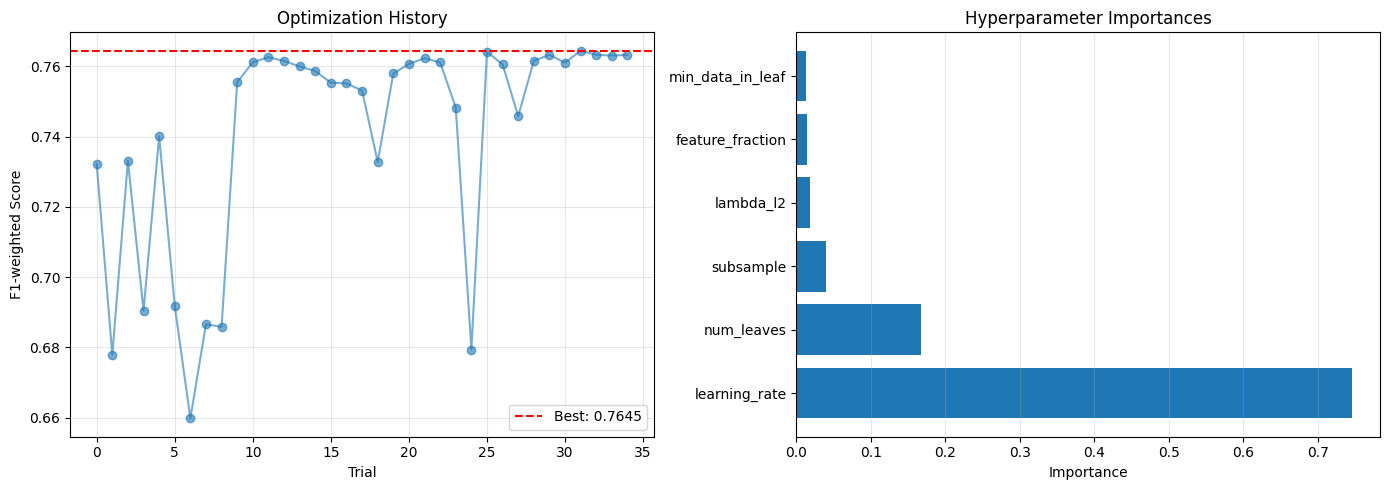


Hyperparameter tuning completed!


In [0]:
# ============================================
# HYPERPARAMETER TUNING WITH OPTUNA
# ============================================

import optuna
import mlflow
import lightgbm as lgb
import numpy as np
from sklearn.metrics import f1_score

# Set MLflow experiment
mlflow.set_experiment("/Users/rajesh.patil@equitable.com/lgbm_hyperparameter_tuning")

def objective(trial):
    """
    Optuna objective function for LightGBM hyperparameter tuning.
    """
    # Suggest hyperparameters
    params = {
        "objective": "multiclass",
        "num_class": NUM_CLASSES,
        "metric": "multi_logloss",
        "boosting_type": "gbdt",
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.1, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 31, 127),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 20, 100),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.6, 1.0),
        "subsample": trial.suggest_float("subsample", 0.6, 1.0),
        "subsample_freq": 1,
        "lambda_l2": trial.suggest_float("lambda_l2", 0.1, 10.0, log=True),
        "verbosity": -1,
        "random_state": 42
    }
    
    # Create fresh Dataset objects for this trial
    train_ds_trial = lgb.Dataset(train_pd[feature_cols_final], label=train_pd["label"], params={"feature_pre_filter": False})
    val_ds_trial = lgb.Dataset(val_pd[feature_cols_final], label=val_pd["label"], reference=train_ds_trial, params={"feature_pre_filter": False})
    
    # Start MLflow run
    with mlflow.start_run(nested=True):
        # Log parameters
        mlflow.log_params(params)
        
        # Train model with early stopping
        model = lgb.train(
            params,
            train_ds_trial,
            num_boost_round=2000,
            valid_sets=[val_ds_trial],
            valid_names=["valid_0"],
            callbacks=[
                lgb.early_stopping(stopping_rounds=50, verbose=False)
            ]
        )
        
        # Predict on validation set
        val_preds_proba = model.predict(val_pd[feature_cols_final])
        val_preds = np.argmax(val_preds_proba, axis=1)
        
        # Calculate F1 score (weighted)
        f1_weighted = f1_score(val_pd["label"], val_preds, average="weighted")
        
        # Log metrics
        mlflow.log_metric("f1_weighted", f1_weighted)
        mlflow.log_metric("best_iteration", model.best_iteration)
        
    return f1_weighted

# Create Optuna study
print("Starting hyperparameter tuning with Optuna...")
print(f"Number of trials: 50")
print(f"Optimization metric: F1-weighted score\n")

with mlflow.start_run(run_name="optuna_hyperparameter_tuning"):
    study = optuna.create_study(
        direction="maximize",
        study_name="lgbm_product_prediction",
        sampler=optuna.samplers.TPESampler(seed=42)
    )
    
    study.optimize(objective, n_trials=35, show_progress_bar=True)
    
    # Log best parameters and score
    print("\n" + "="*60)
    print("HYPERPARAMETER TUNING RESULTS")
    print("="*60)
    print(f"\nBest F1-weighted score: {study.best_value:.4f}")
    print(f"\nBest hyperparameters:")
    for key, value in study.best_params.items():
        print(f"  {key}: {value}")
        mlflow.log_param(f"best_{key}", value)
    
    mlflow.log_metric("best_f1_weighted", study.best_value)
    
    # Create optimization history plot
    try:
        import matplotlib.pyplot as plt
        
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
        
        # Plot optimization history
        trials_df = study.trials_dataframe()
        ax1.plot(trials_df["number"], trials_df["value"], marker="o", alpha=0.6)
        ax1.axhline(y=study.best_value, color="r", linestyle="--", label=f"Best: {study.best_value:.4f}")
        ax1.set_xlabel("Trial")
        ax1.set_ylabel("F1-weighted Score")
        ax1.set_title("Optimization History")
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        
        # Plot parameter importances
        try:
            importances = optuna.importance.get_param_importances(study)
            params_sorted = sorted(importances.items(), key=lambda x: x[1], reverse=True)
            param_names = [p[0] for p in params_sorted]
            param_values = [p[1] for p in params_sorted]
            
            ax2.barh(param_names, param_values)
            ax2.set_xlabel("Importance")
            ax2.set_title("Hyperparameter Importances")
            ax2.grid(True, alpha=0.3, axis="x")
        except:
            ax2.text(0.5, 0.5, "Not enough trials\nfor importance analysis", 
                    ha="center", va="center", transform=ax2.transAxes)
        
        plt.tight_layout()
        mlflow.log_figure(fig, "optimization_history.png")
        plt.show()
    except Exception as e:
        print(f"\nNote: Could not create visualization: {e}")

print("\n" + "="*60)
print("Hyperparameter tuning completed!")
print("="*60)

In [0]:
# ============================================
# SAVE BEST MODEL FROM HYPERPARAMETER TUNING
# ============================================

import mlflow
import mlflow.lightgbm
from mlflow.models import infer_signature
import lightgbm as lgb
import numpy as np

print("="*60)
print("SAVING BEST MODEL FROM HYPERPARAMETER TUNING")
print("="*60)
print(f"\nBest F1-weighted score: {study.best_value:.4f}")
print(f"\nBest hyperparameters:")
for key, value in study.best_params.items():
    print(f"  {key}: {value}")

# Build final model parameters with best hyperparameters
final_params = {
    "objective": "multiclass",
    "num_class": NUM_CLASSES,
    "metric": "multi_logloss",
    "boosting_type": "gbdt",
    "verbosity": -1,
    "random_state": 42
}
final_params.update(study.best_params)

# Create datasets
train_ds_final = lgb.Dataset(train_pd[feature_cols_final], label=train_pd["label"], params={"feature_pre_filter": False})
val_ds_final = lgb.Dataset(val_pd[feature_cols_final], label=val_pd["label"], reference=train_ds_final, params={"feature_pre_filter": False})

# Train final model with best hyperparameters
print("\nTraining final model with best parameters...")
best_model = lgb.train(
    final_params,
    train_ds_final,
    num_boost_round=2000,
    valid_sets=[val_ds_final],
    valid_names=["valid_0"],
    callbacks=[lgb.early_stopping(stopping_rounds=50, verbose=False)]
)

print(f"Training complete! Best iteration: {best_model.best_iteration}")

# Prepare signature
input_example = train_pd[feature_cols_final].iloc[:5]
output_example = best_model.predict(input_example)
signature = infer_signature(input_example, output_example)

# Log and register model to Unity Catalog
print("\nRegistering model to Unity Catalog...")

with mlflow.start_run():
    mlflow.lightgbm.log_model(
        best_model,
        artifact_path="lgbm_model_hyperparameter_310126",
        registered_model_name="eda_smartlist.models.lgbm_model_hyperparameter_310126",
        signature=signature,
        input_example=input_example
    )

print("\n" + "="*60)
print("✓ MODEL SAVED SUCCESSFULLY!")
print("="*60)
print(f"Model name: eda_smartlist.models.lgbm_model_hyperparameter_310126")
print(f"\nTo load: mlflow.lightgbm.load_model('models:/eda_smartlist.models.lgbm_model_hyperparameter_310126/1')")
print("="*60)

SAVING BEST MODEL FROM HYPERPARAMETER TUNING

Best F1-weighted score: 0.7645

Best hyperparameters:
  learning_rate: 0.0695518069908889
  num_leaves: 127
  min_data_in_leaf: 60
  feature_fraction: 0.630270313825708
  subsample: 0.7615852786056677
  lambda_l2: 0.32763277320241313

Training final model with best parameters...


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Training complete! Best iteration: 1999

Registering model to Unity Catalog...


/databricks/python/lib/python3.12/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(


Uploading artifacts:   0%|          | 0/11 [00:00<?, ?it/s]

Successfully registered model 'eda_smartlist.models.lgbm_model_hyperparameter_310126'.


Uploading artifacts:   0%|          | 0/11 [00:00<?, ?it/s]


✓ MODEL SAVED SUCCESSFULLY!
Model name: eda_smartlist.models.lgbm_model_hyperparameter_310126

To load: mlflow.lightgbm.load_model('models:/eda_smartlist.models.lgbm_model_hyperparameter_310126/1')


Created version '1' of model 'eda_smartlist.models.lgbm_model_hyperparameter_310126'.


BEST MODEL EVALUATION ON TEST SET

Test Set Performance:
  Accuracy:      0.7772
  F1 Weighted:   0.7758
  F1 Macro:      0.6385
  Best Iteration: 1999

Comparison with Optuna Validation F1:
  Optuna Best F1 (validation): 0.7645
  Test F1 (weighted):          0.7758
  Difference:                  0.0113

CLASSIFICATION REPORT
                  precision    recall  f1-score   support

      DISABILITY       0.81      0.76      0.78       117
          HEALTH       0.00      0.00      0.00         0
      INVESTMENT       0.74      0.75      0.74      6239
  LIFE_INSURANCE       0.80      0.83      0.81      7563
NETWORK_PRODUCTS       0.81      0.65      0.72      3409
           OTHER       0.88      0.47      0.61       349
      RETIREMENT       0.77      0.82      0.80      8934

        accuracy                           0.78     26611
       macro avg       0.69      0.61      0.64     26611
    weighted avg       0.78      0.78      0.78     26611


CONFUSION MATRIX


/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


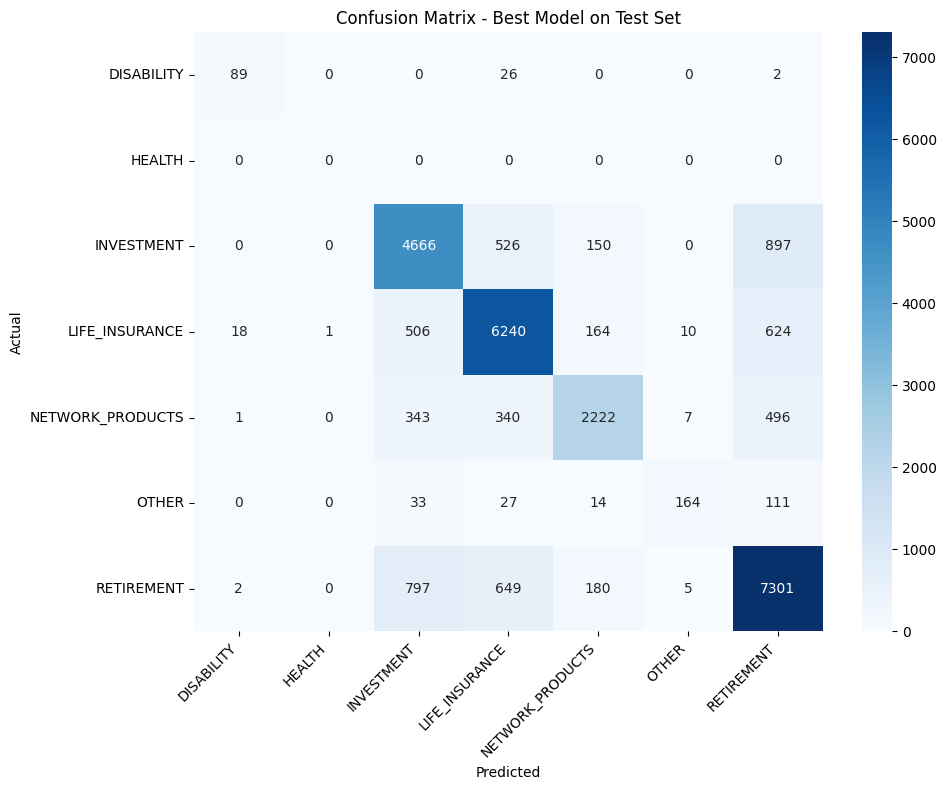


VERIFICATION COMPLETE


In [0]:
# ============================================
# VERIFY BEST MODEL PERFORMANCE
# ============================================

import numpy as np
from sklearn.metrics import f1_score, accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

print("="*60)
print("BEST MODEL EVALUATION ON TEST SET")
print("="*60)

# Predict on test set
test_pred_prob = best_model.predict(test_pd[feature_cols_final])
test_pred = np.argmax(test_pred_prob, axis=1)

# Calculate metrics
test_acc = accuracy_score(test_pd["label"], test_pred)
test_f1_weighted = f1_score(test_pd["label"], test_pred, average="weighted")
test_f1_macro = f1_score(test_pd["label"], test_pred, average="macro")

print(f"\nTest Set Performance:")
print(f"  Accuracy:      {test_acc:.4f}")
print(f"  F1 Weighted:   {test_f1_weighted:.4f}")
print(f"  F1 Macro:      {test_f1_macro:.4f}")
print(f"  Best Iteration: {best_model.best_iteration}")

print(f"\nComparison with Optuna Validation F1:")
print(f"  Optuna Best F1 (validation): {study.best_value:.4f}")
print(f"  Test F1 (weighted):          {test_f1_weighted:.4f}")
print(f"  Difference:                  {test_f1_weighted - study.best_value:.4f}")

# Classification report
print("\n" + "="*60)
print("CLASSIFICATION REPORT")
print("="*60)
print(classification_report(test_pd["label"], test_pred, target_names=[id2prod[i] for i in range(NUM_CLASSES)]))

# Confusion matrix
cm = confusion_matrix(test_pd["label"], test_pred)
print("\n" + "="*60)
print("CONFUSION MATRIX")
print("="*60)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=[id2prod[i] for i in range(NUM_CLASSES)],
            yticklabels=[id2prod[i] for i in range(NUM_CLASSES)])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Best Model on Test Set')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

print("\n" + "="*60)
print("VERIFICATION COMPLETE")
print("="*60)

feature,importance
first_product_category_idx,614868.0520136177
years_to_second_policy,606632.8634556913
age_at_first_policy,334390.2795701532
first_face_amt,249632.29545391412
psn_age,232997.72288634992
branchoffice_code_idx,230476.6776594132
first_acct_val_amt,205407.05867036618
annuity_allocation_ratio,170600.10726332146
agent_segment_idx,127868.11727473701
first_cash_val_amt,126458.83401102843


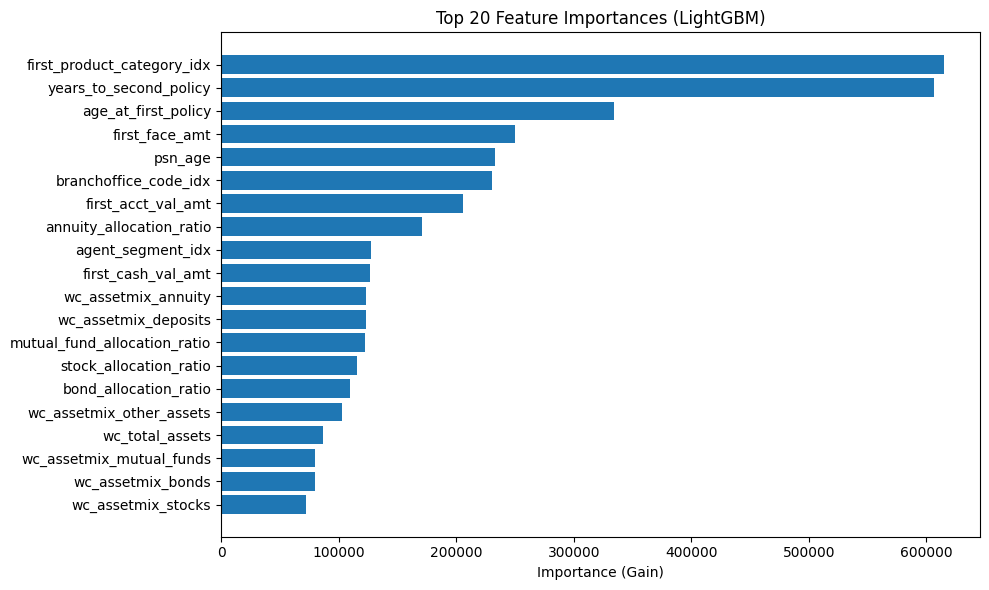

In [0]:
import matplotlib.pyplot as plt
import pandas as pd

# Get feature importances from the trained LightGBM model
feature_importances = model.feature_importance(importance_type='gain')
feature_names = feature_cols_final

# Create a DataFrame for better visualization
feat_imp_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importances
}).sort_values('importance', ascending=False)

# Display top 20 features
display(feat_imp_df.head(20))

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(feat_imp_df.head(20)['feature'][::-1], feat_imp_df.head(20)['importance'][::-1])
plt.xlabel('Importance (Gain)')
plt.title('Top 20 Feature Importances (LightGBM)')
plt.tight_layout()
plt.show()

In [0]:
import mlflow
import mlflow.lightgbm
from mlflow.models import infer_signature

# Use train_pd and model from previous cells
input_example = train_pd[feature_cols_final].iloc[:5]
output_example = model.predict(input_example)
signature = infer_signature(input_example, output_example)

with mlflow.start_run():
    mlflow.lightgbm.log_model(
        model,
        artifact_path="lgbm_model_300126",
        registered_model_name="eda_smartlist.models.lgbm_model_300126",
        signature=signature,
        input_example=input_example
    )

/databricks/python/lib/python3.12/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(


Uploading artifacts:   0%|          | 0/11 [00:00<?, ?it/s]

Registered model 'eda_smartlist.models.lgbm_model_300126' already exists. Creating a new version of this model...


Uploading artifacts:   0%|          | 0/11 [00:00<?, ?it/s]

Created version '3' of model 'eda_smartlist.models.lgbm_model_300126'.


In [0]:
# register and create an alias

from mlflow import MlflowClient

client = MlflowClient()
model_name = "eda_smartlist.models.lgbm_model_300126"
model_version = "3"  
alias = "lgbm3"

client.set_registered_model_alias(
    name=model_name,
    alias=alias,
    version=model_version
)

In [0]:
# ============================================
# PREDICTIONS FOR BRANCH OFFICE 83 - MOST RECENT BUSINESS_MONTH
# ============================================

from pyspark.sql import functions as F, Window
from pyspark.sql.types import StructType, StructField, StringType, ArrayType, IntegerType
import numpy as np
import pandas as pd
from collections import Counter

# ------------- 1) Load filtered data: branchoffice_code='83' and most recent business_month -------------
df_pred_raw = spark.table("dl_tenants_daas.us_wealth_management.wealth_management_client_metrics")

# Apply product_category transformation (same as training)
df_pred_raw = df_pred_raw.withColumn(
    "product_category",
    F.when(F.col("prod_lob") == "LIFE", "LIFE_INSURANCE")
    .when(F.col("sub_product_level_1").isin("VLI", "WL", "UL/IUL", "TERM", "PROTECTIVE PRODUCT"), "LIFE_INSURANCE")
    .when(F.col("sub_product_level_2").like("%LIFE%"), "LIFE_INSURANCE")
    .when(F.col("sub_product_level_2").isin(
        "VARIABLE UNIVERSAL LIFE", "WHOLE LIFE", "UNIVERSAL LIFE",
        "INDEX UNIVERSAL LIFE", "TERM PRODUCT", "VARIABLE LIFE",
        "SURVIVORSHIP WHOLE LIFE", "MONY PROTECTIVE PRODUCT"
    ), "LIFE_INSURANCE")
    .when(F.col("prod_lob").isin("GROUP RETIREMENT", "INDIVIDUAL RETIREMENT"), "RETIREMENT")
    .when(F.col("sub_product_level_1").isin(
        "EQUIVEST", "RETIREMENT 401K", "ACCUMULATOR",
        "RETIREMENT CORNERSTONE", "SCS", "INVESTMENT EDGE"
    ), "RETIREMENT")
    .when(
        (F.col("sub_product_level_2").like("%403B%")) |
        (F.col("sub_product_level_2").like("%401%")) |
        (F.col("sub_product_level_2").like("%IRA%")) |
        (F.col("sub_product_level_2").like("%SEP%")),
        "RETIREMENT"
    )
    .when(F.col("prod_lob") == "BROKER DEALER", "INVESTMENT")
    .when(F.col("sub_product_level_1").isin(
        "INVESTMENT PRODUCT - DIRECT", "INVESTMENT PRODUCT - BROKERAGE",
        "INVESTMENT PRODUCT - ADVISORY", "DIRECT", "BROKERAGE",
        "ADVISORY", "CASH SOLICITOR"
    ), "INVESTMENT")
    .when(
        (F.col("sub_product_level_2").like("%Investment%")) |
        (F.col("sub_product_level_2").like("%Brokerage%")) |
        (F.col("sub_product_level_2").like("%Advisory%")),
        "INVESTMENT"
    )
    .when(F.col("prod_lob") == "NETWORK", "NETWORK_PRODUCTS")
    .when(
        (F.col("sub_product_level_1") == "NETWORK PRODUCTS") |
        (F.col("sub_product_level_2") == "NETWORK PRODUCTS"),
        "NETWORK_PRODUCTS"
    )
    .when(
        (F.col("prod_lob") == "OTHERS") & (F.col("sub_product_level_1") == "HAS"),
        "DISABILITY"
    )
    .when(F.col("sub_product_level_2") == "HAS - DISABILITY", "DISABILITY")
    .when(F.col("prod_lob") == "OTHERS", "HEALTH")
    .when(F.col("sub_product_level_2") == "GROUP HEALTH PRODUCTS", "HEALTH")
    .otherwise("OTHER")
)

# Filter for branchoffice_code = '83'
df_pred_raw = df_pred_raw.filter(F.col("branchoffice_code") == "83")

# Get most recent business_month
max_business_month = df_pred_raw.select(F.max("business_month").alias("max_month")).collect()[0]["max_month"]
print(f"Most recent business_month: {max_business_month}")

# Filter for most recent business_month
df_pred_raw = df_pred_raw.filter(F.col("business_month") == max_business_month)

print(f"Rows for prediction (branchoffice_code='83', business_month={max_business_month}): {df_pred_raw.count()}")

# ------------- 2) Prepare events data (similar to training) -------------
df_pred_events = df_pred_raw.select(
    "cont_id", "product_category", "register_date",
    "acct_val_amt","face_amt","cash_val_amt","wc_total_assets",
    "wc_assetmix_stocks","wc_assetmix_bonds","wc_assetmix_mutual_funds",
    "wc_assetmix_annuity","wc_assetmix_deposits","wc_assetmix_other_assets",
    "psn_age","client_seg","client_seg_1","aum_band","channel","agent_segment",
    "branchoffice_code","policy_status", "business_month"
).filter(
    (F.col("cont_id").isNotNull()) &
    (F.col("register_date").isNotNull()) &
    (F.col("product_category").isNotNull())
)

# Keep only Active policies
df_pred_events = df_pred_events.filter(F.col("policy_status") == "Active")

# Order events per user
df_pred_events = df_pred_events.withColumn("register_ts", F.to_timestamp("register_date"))
w_pred = Window.partitionBy("cont_id").orderBy("register_ts")
df_pred_events = df_pred_events.withColumn("event_idx", F.row_number().over(w_pred))

# ------------- 3) Build sequences for prediction (need full history up to prediction point) -------------
# For prediction, we need to get the full history for each client up to the most recent business_month
# We'll use ALL historical events (not just from the filtered month) to build sequences

# Get all historical events for clients in branchoffice_code='83' (for sequence building)
df_all_hist = spark.table("dl_tenants_daas.us_wealth_management.wealth_management_client_metrics")
df_all_hist = df_all_hist.withColumn(
    "product_category",
    F.when(F.col("prod_lob") == "LIFE", "LIFE_INSURANCE")
    .when(F.col("sub_product_level_1").isin("VLI", "WL", "UL/IUL", "TERM", "PROTECTIVE PRODUCT"), "LIFE_INSURANCE")
    .when(F.col("sub_product_level_2").like("%LIFE%"), "LIFE_INSURANCE")
    .when(F.col("sub_product_level_2").isin(
        "VARIABLE UNIVERSAL LIFE", "WHOLE LIFE", "UNIVERSAL LIFE",
        "INDEX UNIVERSAL LIFE", "TERM PRODUCT", "VARIABLE LIFE",
        "SURVIVORSHIP WHOLE LIFE", "MONY PROTECTIVE PRODUCT"
    ), "LIFE_INSURANCE")
    .when(F.col("prod_lob").isin("GROUP RETIREMENT", "INDIVIDUAL RETIREMENT"), "RETIREMENT")
    .when(F.col("sub_product_level_1").isin(
        "EQUIVEST", "RETIREMENT 401K", "ACCUMULATOR",
        "RETIREMENT CORNERSTONE", "SCS", "INVESTMENT EDGE"
    ), "RETIREMENT")
    .when(
        (F.col("sub_product_level_2").like("%403B%")) |
        (F.col("sub_product_level_2").like("%401%")) |
        (F.col("sub_product_level_2").like("%IRA%")) |
        (F.col("sub_product_level_2").like("%SEP%")),
        "RETIREMENT"
    )
    .when(F.col("prod_lob") == "BROKER DEALER", "INVESTMENT")
    .when(F.col("sub_product_level_1").isin(
        "INVESTMENT PRODUCT - DIRECT", "INVESTMENT PRODUCT - BROKERAGE",
        "INVESTMENT PRODUCT - ADVISORY", "DIRECT", "BROKERAGE",
        "ADVISORY", "CASH SOLICITOR"
    ), "INVESTMENT")
    .when(
        (F.col("sub_product_level_2").like("%Investment%")) |
        (F.col("sub_product_level_2").like("%Brokerage%")) |
        (F.col("sub_product_level_2").like("%Advisory%")),
        "INVESTMENT"
    )
    .when(F.col("prod_lob") == "NETWORK", "NETWORK_PRODUCTS")
    .when(
        (F.col("sub_product_level_1") == "NETWORK PRODUCTS") |
        (F.col("sub_product_level_2") == "NETWORK PRODUCTS"),
        "NETWORK_PRODUCTS"
    )
    .when(
        (F.col("prod_lob") == "OTHERS") & (F.col("sub_product_level_1") == "HAS"),
        "DISABILITY"
    )
    .when(F.col("sub_product_level_2") == "HAS - DISABILITY", "DISABILITY")
    .when(F.col("prod_lob") == "OTHERS", "HEALTH")
    .when(F.col("sub_product_level_2") == "GROUP HEALTH PRODUCTS", "HEALTH")
    .otherwise("OTHER")
)

# Get list of cont_ids we need to predict for
cont_ids_to_predict = [r["cont_id"] for r in df_pred_events.select("cont_id").distinct().collect()]

# Filter historical data for these clients and events up to (and including) the prediction month
df_all_hist = df_all_hist.filter(
    (F.col("cont_id").isin(cont_ids_to_predict)) &
    (F.col("branchoffice_code") == "83") &
    (F.col("cont_id").isNotNull()) &
    (F.col("register_date").isNotNull()) &
    (F.col("product_category").isNotNull()) &
    (F.col("policy_status") == "Active")
)

# Filter events up to and including the prediction business_month
df_all_hist = df_all_hist.filter(F.col("business_month") <= max_business_month)

# Order events per user
df_all_hist = df_all_hist.withColumn("register_ts", F.to_timestamp("register_date"))
w_hist = Window.partitionBy("cont_id").orderBy("register_ts")
df_all_hist = df_all_hist.withColumn("event_idx", F.row_number().over(w_hist))

print(f"Historical events for prediction clients: {df_all_hist.count()}")

# ------------- 4) Build sequences for prediction (one prediction per client) -------------
# Create RDD of (cont_id, (event_idx, product_category))
rdd_pred = df_all_hist.select("cont_id","event_idx","product_category").rdd.map(
    lambda r: (r["cont_id"], (int(r["event_idx"]), r["product_category"]))
)

# Group by cont_id
grouped_pred = rdd_pred.groupByKey().mapValues(
    lambda evs: [p for _, p in sorted(list(evs), key=lambda x: x[0])]
)

# Remove consecutive duplicates
def dedupe_consecutive(seq):
    if not seq:
        return []
    out = [seq[0]]
    for x in seq[1:]:
        if x != out[-1]:
            out.append(x)
    return out

grouped_pred = grouped_pred.mapValues(dedupe_consecutive).filter(lambda kv: len(kv[1]) >= 1)  # At least 1 event

print(f"Users with sequences for prediction: {grouped_pred.count()}")

# ------------- 5) Create prediction examples (one per client, using full history) -------------
def make_prediction_examples(kv):
    cont_id, seq = kv
    # Map to ids using the same prod2id mapping from training
    seq_ids = [prod2id.get(x, 0) for x in seq]
    if len(seq_ids) == 0:
        return []
    # Use full history (up to MAX_SEQ_LEN) for prediction
    history = seq_ids[-MAX_SEQ_LEN:] if len(seq_ids) > MAX_SEQ_LEN else seq_ids
    return [(str(cont_id), history)]

pred_examples_rdd = grouped_pred.flatMap(make_prediction_examples)

# Convert to DataFrame
pred_schema = StructType([
    StructField("cont_id", StringType(), True),
    StructField("hist_seq", ArrayType(IntegerType()), True),
])
pred_examples_df = spark.createDataFrame(pred_examples_rdd, pred_schema).cache()

print(f"Prediction examples: {pred_examples_df.count()}")

# ------------- 6) Create features for prediction (same as training) -------------
def hist_to_features_row_pred(x):
    cont_id, hist = x
    seq_len = len(hist)
    last_1 = hist[-1] if seq_len >= 1 else 0
    last_2 = hist[-2] if seq_len >= 2 else 0
    unique_prior = len(set(hist))
    num_switches = sum(1 for i in range(1, seq_len) if hist[i] != hist[i-1])
    freq = Counter(hist)
    freq_features = [freq.get(i, 0) for i in range(1, NUM_CLASSES+1)]
    return (str(cont_id), hist, seq_len, last_1, last_2, unique_prior, num_switches, freq_features)

rows_pred_rdd = pred_examples_rdd.map(hist_to_features_row_pred)

from pyspark.sql.types import ArrayType, LongType
feat_pred_schema = StructType([
    StructField("cont_id", StringType(), True),
    StructField("hist_seq", ArrayType(IntegerType()), True),
    StructField("seq_len", IntegerType(), True),
    StructField("last_1", IntegerType(), True),
    StructField("last_2", IntegerType(), True),
    StructField("unique_prior", IntegerType(), True),
    StructField("num_switches", IntegerType(), True),
    StructField("freq_list", ArrayType(IntegerType()), True),
])

pred_feats_df = spark.createDataFrame(rows_pred_rdd, feat_pred_schema).cache()

# Expand freq_list into separate columns
for i in range(1, NUM_CLASSES+1):
    pred_feats_df = pred_feats_df.withColumn(f"freq_{i}", F.col("freq_list")[i-1])
pred_feats_df = pred_feats_df.drop("freq_list")

# ------------- 7) Join with static features from most recent snapshot -------------
w2_pred = Window.partitionBy("cont_id").orderBy(F.col("register_ts").desc())
client_snapshot_pred = (df_pred_events
                       .withColumn("rn", F.row_number().over(w2_pred))
                       .filter(F.col("rn") == 1)
                       .select("cont_id",
                               "acct_val_amt","face_amt","cash_val_amt","wc_total_assets",
                               "wc_assetmix_stocks","wc_assetmix_bonds","wc_assetmix_mutual_funds",
                               "wc_assetmix_annuity","wc_assetmix_deposits","wc_assetmix_other_assets",
                               "psn_age","client_seg","client_seg_1","aum_band","channel","agent_segment","branchoffice_code", "business_month"))

pred_full = pred_feats_df.join(client_snapshot_pred, on="cont_id", how="inner")

print(f"Prediction examples after join: {pred_full.count()}")

# ------------- 8) Fill missing values (same as training) -------------
numeric_cols_pred = [c for c, t in pred_full.dtypes if t in ("int", "double", "bigint", "float") and c not in ("seq_len","last_1","last_2","unique_prior","num_switches")]
fill_dict_pred = {c: 0 for c in numeric_cols_pred}

categorical_cols = ["client_seg","client_seg_1","aum_band","channel","agent_segment","branchoffice_code"]
modes_pred = {}
for c in categorical_cols:
    try:
        m = pred_full.groupBy(c).count().orderBy(F.desc("count")).first()
        modes_pred[c] = m[0] if m and m[0] is not None else "UNKNOWN"
    except:
        modes_pred[c] = "UNKNOWN"

pred_full = pred_full.fillna(fill_dict_pred)
for c in categorical_cols:
    pred_full = pred_full.withColumn(c, F.when(F.col(c).isNull(), F.lit(modes_pred[c])).otherwise(F.col(c)))

# ------------- 9) Convert hist_seq to fixed-length padded columns -------------
def pad_history(hist):
    arr = hist[-MAX_SEQ_LEN:] if hist is not None else []
    pad_len = MAX_SEQ_LEN - len(arr)
    return [0]*pad_len + arr

pad_udf = F.udf(lambda x: pad_history(x), ArrayType(IntegerType()))
pred_full = pred_full.withColumn("hist_padded", pad_udf(F.col("hist_seq")))

for i in range(MAX_SEQ_LEN):
    pred_full = pred_full.withColumn(f"hist_{i}", F.col("hist_padded")[i])

pred_full = pred_full.drop("hist_seq", "hist_padded")

# ------------- 10) Convert categorical strings to index (same as training) -------------
# Use the same categorical mappings from training (we need to recreate them or use broadcast)
# For now, we'll recreate the mappings from pred_full
for c in categorical_cols:
    vals = [r[0] for r in pred_full.select(c).distinct().collect()]
    m = {v:i for i,v in enumerate(sorted([str(x) for x in vals]))}
    b = spark.sparkContext.broadcast(m)
    pred_full = pred_full.withColumn(c + "_idx", F.coalesce(F.col(c).cast("string"), F.lit("UNKNOWN")))
    pred_full = pred_full.withColumn(c + "_idx", F.udf(lambda s: int(b.value.get(str(s), 0)), IntegerType())(F.col(c + "_idx")))

# ------------- 11) Convert to Pandas and prepare for prediction -------------
pred_pd = pred_full.select(["cont_id", "business_month"] + model_feature_cols).toPandas()
pred_pd.fillna(0, inplace=True)

print(f"Prediction data shape: {pred_pd.shape}")

# ------------- 12) Make predictions -------------
pred_probs = model.predict(pred_pd[feature_cols_final])
pred_class_ids = np.argmax(pred_probs, axis=1)

# Convert to product names using the same mapping from training
inv_label_map = {v: k for k, v in label_map.items()}
final_id2prod = {model_id: id2prod[original_id] for model_id, original_id in inv_label_map.items()}

pred_pd["pred_class_id"] = pred_class_ids
pred_pd["pred_product"] = pred_pd["pred_class_id"].apply(lambda x: final_id2prod.get(x, "UNKNOWN"))

# Add probability columns
num_classes_pred = pred_probs.shape[1]
for i in range(num_classes_pred):
    pred_pd[f"prob_{i}"] = pred_probs[:, i]
pred_pd["pred_prob"] = pred_pd.apply(lambda r: r[f"prob_{r['pred_class_id']}"], axis=1)


# ------------- 13) Add additional client information -------------
from pyspark.sql.functions import to_date, current_date, datediff, round as spark_round

axa_map_df_pred = (
    df_pred_raw
    .withColumn("client_tenure", spark_round(datediff(current_date(), to_date("register_date")) / 365.25, 2))
    .select(
        "cont_id", "axa_party_id", "product_category", "psn_age", "client_seg", "client_seg_1",
        "aum_band", "channel", "division_name", "branch_name", "business_city", "business_state_cod", "client_tenure"
    )
    .dropDuplicates(["cont_id"])
)

axa_map_pd_pred = axa_map_df_pred.toPandas().drop_duplicates("cont_id")

# Ensure psn_age is present in both DataFrames and handle column suffixes if duplicated after merge
final_predictions = pred_pd.merge(axa_map_pd_pred, on="cont_id", how="left", suffixes=("", "_dem"))

# If both pred_pd and axa_map_pd_pred have psn_age, pandas will add suffixes. Prefer the demographic version if present.
if "psn_age_dem" in final_predictions.columns:
    final_predictions["psn_age"] = final_predictions["psn_age_dem"]
    final_predictions = final_predictions.drop(columns=["psn_age_dem"])

# Select final columns
prob_cols_final = [c for c in final_predictions.columns if c.startswith("prob_")]
final_cols_list = [
    "cont_id", "axa_party_id", "product_category", "psn_age", "client_seg", "client_seg_1",
    "aum_band", "channel", "division_name", "branch_name", "business_city", "business_state_cod", "client_tenure",
    "pred_class_id", "pred_product", "pred_prob"
] + prob_cols_final

final_predictions = final_predictions[final_cols_list]

print(f"\nFinal predictions shape: {final_predictions.shape}")
print(f"\nFinal predictions sample:")
display(final_predictions.head(10))

print("\nPrediction summary:")
print(final_predictions["pred_product"].value_counts())

Most recent business_month: 202511
Rows for prediction (branchoffice_code='83', business_month=202511): 300955
Historical events for prediction clients: 15058055
Users with sequences for prediction: 245728
Prediction examples: 245728
Prediction examples after join: 245728
Prediction data shape: (245728, 41)

Final predictions shape: (245728, 23)

Final predictions sample:


cont_id,axa_party_id,product_category,psn_age,client_seg,client_seg_1,aum_band,channel,division_name,branch_name,business_city,business_state_cod,client_tenure,pred_class_id,pred_product,pred_prob,prob_0,prob_1,prob_2,prob_3,prob_4,prob_5,prob_6
100236768405239730,00BK05RY3MBBYZETXXXX,RETIREMENT,67.0,1-2.99m,Next Chapters,<$25K,Branch Assist,Division 8,PCPG,SYRACUSE,NY,35.47,3,LIFE_INSURANCE,0.5938047262505148,0.0012894623356847466,1.6900128581065633E-6,0.304129020734926,0.5938047262505148,0.05471542317824895,0.046018349081623194,4.132840614402719E-5
100236775740980032,94YK0DQHXLXIDUTAXXXX,LIFE_INSURANCE,60.0,<200k,Strategic Spenders,$50-$100K,Branch Assist,Division 8,PCPG,SYRACUSE,NY,10.58,5,OTHER,0.3959357872039781,0.017404929202043926,3.096362893112268E-5,0.212794693854749,0.004068445586196477,0.11514574458162888,0.3959357872039781,0.25461943594247255
100336777803286137,03BK05RY51WW64PHXXXX,LIFE_INSURANCE,73.0,<200k,Strategic Spenders,<$25K,Branch Assist,Division 8,PCPG,SYRACUSE,NY,24.43,4,NETWORK_PRODUCTS,0.898848040500579,0.0017949733570290158,1.816864919724236E-6,0.04189879744226347,0.0020453718716081848,0.898848040500579,0.004626477713615976,0.05078452224998479
100367602181183095,96YK0DQHXI9402H9XXXX,LIFE_INSURANCE,71.0,1-2.99m,Next Chapters,<$25K,Branch Assist,Division 8,PCPG,SYRACUSE,NY,22.35,6,RETIREMENT,0.46700793050411765,0.0037475398256119606,6.702267388993642E-6,0.16738946721691433,0.0055117268913735095,0.292494741219604,0.06384189207498951,0.46700793050411765
100367742412104944,31YK0DQHXNK0ROV0XXXX,LIFE_INSURANCE,74.0,1-2.99m,Next Chapters,<$25K,Branch Assist,Division 8,PCPG,SYRACUSE,NY,64.22,6,RETIREMENT,0.8291345205905127,9.547981798185405E-4,4.264798620555953E-6,0.08004212092208692,0.002249119795801198,0.06982843240524862,0.017786743307911478,0.8291345205905127
100436767891559904,55BK0RJOHQPUQDW8XXXX,LIFE_INSURANCE,46.0,1-2.99m,Wealth Builders,<$25K,Branch Assist,Division 8,PCPG,SYRACUSE,NY,15.41,5,OTHER,0.44189686614316537,4.923944050793394E-4,1.3373821540548045E-4,0.19472759071849458,0.0029328647034959922,0.0976988924076201,0.44189686614316537,0.2621176534067392
100436778268667989,66BK05RY2G9MGHQYXXXX,LIFE_INSURANCE,88.0,3-4.99m,Life Legacies,<$25K,Branch Assist,Division 8,PCPG,SYRACUSE,NY,67.45,6,RETIREMENT,0.8748926140368007,6.886450599959803E-4,4.457037343788962E-6,0.05420707579492654,0.0013237483779768844,0.06766500893741763,0.0012184507555384047,0.8748926140368007
100536768419521458,64BK05RY3MX4DAPEXXXX,RETIREMENT,59.0,<200k,Strategic Spenders,<$25K,Branch Assist,Division 8,PCPG,SYRACUSE,NY,32.93,3,LIFE_INSURANCE,0.37199248064986423,6.067432735407653E-4,1.2397286382229538E-6,0.31438021989287906,0.37199248064986423,0.04018421636458055,0.2727885497353888,4.6550355108367394E-5
100636768966578192,83BK05RY3MX5OGVGXXXX,RETIREMENT,73.0,200-399k,Strategic Spenders,$50-$100K,Branch Assist,Division 8,PCPG,SYRACUSE,NY,10.56,3,LIFE_INSURANCE,0.7336613204298862,8.442334025892909E-5,1.0360020716577716E-6,0.11884209566982998,0.7336613204298862,0.09296796855916155,0.054419793482903205,2.3362515888471893E-5
100658269393234144,20208ac72304946245c7,LIFE_INSURANCE,75.0,1-2.99m,Next Chapters,<$25K,Branch Assist,Division 8,PCPG,SYRACUSE,NY,51.71,6,RETIREMENT,0.6369366973193312,0.0036561512962371523,2.4741755891599476E-6,0.1308979938624453,0.0028386100434686272,0.1424697282705258,0.08319834503240277,0.6369366973193312



Prediction summary:
RETIREMENT          130923
LIFE_INSURANCE       57470
OTHER                29847
NETWORK_PRODUCTS     20517
INVESTMENT            6011
DISABILITY             945
HEALTH                  15
Name: pred_product, dtype: int64


In [0]:
#### 13th step

In [0]:
# spark.createDataFrame(final_predictions).write.mode("overwrite").saveAsTable("eda_smartlist.us_wealth_management_smartlist.transformer4_202510_83")

In [0]:
prod_list
prod2id
label_map
id2prod

{1: 'DISABILITY',
 2: 'HEALTH',
 3: 'INVESTMENT',
 4: 'LIFE_INSURANCE',
 5: 'NETWORK_PRODUCTS',
 6: 'OTHER',
 7: 'RETIREMENT'}

In [0]:
prod2id

{'DISABILITY': 1,
 'HEALTH': 2,
 'INVESTMENT': 3,
 'LIFE_INSURANCE': 4,
 'NETWORK_PRODUCTS': 5,
 'OTHER': 6,
 'RETIREMENT': 7}

# SHAP Analysis for LightGBM Model

## Purpose
SHAP (SHapley Additive exPlanations) is a powerful tool used to interpret the predictions of machine learning models. It provides insights into how each feature contributes to the model's predictions, allowing us to understand the model's behavior better. In the context of a LightGBM model, SHAP helps us identify feature importance and offers explanations for individual predictions.

## Steps
1. **Compute SHAP Values**: We will calculate the SHAP values for the LightGBM model, which quantify the contribution of each feature to the model's output.
2. **Summary Plots**: We will generate summary plots to visualize the distribution of SHAP values across all predictions, highlighting the most important features.
3. **Feature Importances**: Finally, we will display the feature importances derived from the SHAP values, providing a clear view of which features are driving the model's predictions.

By following these steps, we can gain a deeper understanding of our LightGBM model and ensure that our predictions are interpretable and trustworthy.

In [0]:
# ============================================
# SHAP ANALYSIS FOR PREDICTIONS + AGENT TALKING POINTS
# ============================================

import shap
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

print("=" * 60)
print("SHAP ANALYSIS FOR CLIENT PREDICTIONS")
print("=" * 60)

# Use prediction data for SHAP analysis (sample if too large)
shap_sample_size = min(100, len(pred_pd))
shap_pred_data = pred_pd[feature_cols_final].iloc[:shap_sample_size].copy()
shap_pred_indices = pred_pd.iloc[:shap_sample_size].index

# Get corresponding final_predictions data for demographic info
if len(final_predictions) >= shap_sample_size:
    shap_final_preds = final_predictions.iloc[:shap_sample_size].copy()
else:
    shap_final_preds = final_predictions.copy()

print(f"\nComputing SHAP values for {len(shap_pred_data)} prediction samples...")
print(f"Number of features: {len(feature_cols_final)}")

# Create SHAP explainer
explainer = shap.TreeExplainer(model)

# Calculate SHAP values for predictions
shap_values_pred = explainer.shap_values(shap_pred_data)

# Handle different SHAP output formats
if isinstance(shap_values_pred, list):
    # List of arrays (one per class)
    num_classes = len(shap_values_pred)
    print(f"SHAP values format: List of {num_classes} arrays")
    print(f"Each array shape: {shap_values_pred[0].shape}")
else:
    # Single array - convert to list format
    shap_array = np.array(shap_values_pred)
    if len(shap_array.shape) == 3:
        # Shape is (n_samples, n_features, n_classes) - need to transpose
        num_classes = shap_array.shape[2]
        shap_values_pred = [shap_array[:, :, i] for i in range(num_classes)]
        print(f"SHAP values format: Array shape {shap_array.shape}, converted to list of {num_classes} arrays")
    else:
        num_classes = 1
        shap_values_pred = [shap_array]
        print(f"SHAP values format: Single array shape {shap_array.shape}")

print(f"Number of classes: {num_classes}")

# ------------- 1) Overall Feature Importance -------------
print("\n" + "=" * 60)
print("OVERALL FEATURE IMPORTANCE")
print("=" * 60)

feature_importance_pred = {}
for i, feat in enumerate(feature_cols_final):
    # Calculate mean absolute SHAP value across all classes
    importance = np.mean([np.mean(np.abs(sv[:, i])) for sv in shap_values_pred])
    feature_importance_pred[feat] = importance

feature_importance_sorted = sorted(feature_importance_pred.items(), key=lambda x: x[1], reverse=True)
shap_importance_df = pd.DataFrame(feature_importance_sorted, columns=['Feature', 'Mean_|SHAP_Value|'])
shap_importance_df['Rank'] = range(1, len(shap_importance_df) + 1)

print("\nTop 15 Most Important Features for Predictions:")
display(shap_importance_df.head(15))

# ------------- 2) Generate Talking Points for Each Client -------------
print("\n" + "=" * 60)
print("GENERATING AGENT TALKING POINTS")
print("=" * 60)

# Get product name mapping
inv_label_map = {v: k for k, v in label_map.items()}
final_id2prod = {model_id: id2prod[original_id] for model_id, original_id in inv_label_map.items()}

# Create talking points DataFrame
talking_points_list = []

for idx in range(len(shap_pred_data)):
    actual_idx = shap_pred_indices[idx]
    client_id = pred_pd.iloc[actual_idx]['cont_id']
    pred_class = pred_pd.iloc[actual_idx]['pred_class_id']
    pred_product = pred_pd.iloc[actual_idx]['pred_product']
    pred_prob = pred_pd.iloc[actual_idx]['pred_prob']
    
    # Get demographic data if available
    client_demo = None
    if idx < len(shap_final_preds):
        client_demo = shap_final_preds.iloc[idx]
    
    # Get SHAP values for the predicted class
    # Ensure pred_class is within valid range
    if pred_class >= len(shap_values_pred):
        pred_class = len(shap_values_pred) - 1
    shap_vals = shap_values_pred[pred_class][idx]
    
    # Get top contributing features (positive and negative)
    feature_contributions = []
    for i, feat in enumerate(feature_cols_final):
        contrib = shap_vals[i]
        feature_contributions.append({
            'feature': feat,
            'shap_value': contrib,
            'feature_value': shap_pred_data.iloc[idx][feat]
        })
    
    # Sort by absolute SHAP value
    feature_contributions.sort(key=lambda x: abs(x['shap_value']), reverse=True)
    
    # Get top 5 positive and top 3 negative contributors
    top_positive = [f for f in feature_contributions if f['shap_value'] > 0][:5]
    top_negative = [f for f in feature_contributions if f['shap_value'] < 0][:3]
    
    # Build talking points
    talking_points = []
    
    # Main recommendation
    talking_points.append(f"Based on your client profile and purchase history, we recommend {pred_product} with {pred_prob*100:.1f}% confidence.")
    
    # Positive drivers
    if top_positive:
        talking_points.append("\nKey reasons for this recommendation:")
        for i, contrib in enumerate(top_positive, 1):
            feat = contrib['feature']
            val = contrib['feature_value']
            shap_val = contrib['shap_value']
            
            # Interpret feature values
            if feat.startswith('hist_'):
                pos = int(feat.split('_')[1])
                if val > 0:
                    product_name = id2prod.get(int(val), f"Product {val}")
                    talking_points.append(f"  {i}. Your recent purchase of {product_name} indicates strong alignment with {pred_product}.")
            
            elif feat == 'last_1':
                if val > 0:
                    product_name = id2prod.get(int(val), f"Product {val}")
                    talking_points.append(f"  {i}. Your most recent product ({product_name}) shows a natural progression to {pred_product}.")
            
            elif feat == 'last_2':
                if val > 0:
                    product_name = id2prod.get(int(val), f"Product {val}")
                    talking_points.append(f"  {i}. Your purchase history including {product_name} suggests {pred_product} would complement your portfolio.")
            
            elif feat.startswith('freq_'):
                prod_id = int(feat.split('_')[1])
                if val > 0:
                    product_name = id2prod.get(prod_id, f"Product {prod_id}")
                    talking_points.append(f"  {i}. Your frequent engagement with {product_name} indicates readiness for {pred_product}.")
            
            elif feat == 'psn_age':
                age_val = int(val) if val > 0 else (int(client_demo['psn_age']) if client_demo is not None and 'psn_age' in client_demo and pd.notna(client_demo['psn_age']) else None)
                if age_val:
                    talking_points.append(f"  {i}. At age {age_val}, {pred_product} aligns well with your life stage and financial planning needs.")
                else:
                    talking_points.append(f"  {i}. Your age profile indicates {pred_product} would be an excellent fit for your financial goals.")
            
            elif feat == 'client_tenure' or 'tenure' in feat.lower():
                tenure_val = val if val > 0 else (client_demo['client_tenure'] if client_demo is not None and 'client_tenure' in client_demo and pd.notna(client_demo['client_tenure']) else None)
                if tenure_val:
                    talking_points.append(f"  {i}. With {tenure_val:.1f} years as our client, {pred_product} represents a natural next step in your relationship with us.")
                else:
                    talking_points.append(f"  {i}. As a valued client, {pred_product} represents a natural next step in your relationship with us.")
            
            elif 'aum' in feat.lower() or 'asset' in feat.lower():
                talking_points.append(f"  {i}. Your asset profile indicates {pred_product} would be an excellent fit for your portfolio.")
            
            elif 'channel' in feat.lower():
                talking_points.append(f"  {i}. Clients in your channel typically benefit from {pred_product}.")
            
            else:
                talking_points.append(f"  {i}. Your {feat.replace('_', ' ')} profile strongly supports {pred_product}.")
    
    # Address potential concerns (negative contributors)
    if top_negative:
        talking_points.append("\nConsiderations:")
        for contrib in top_negative:
            feat = contrib['feature']
            # Only mention if it's a significant concern
            if abs(contrib['shap_value']) > 0.1:
                if 'age' in feat.lower():
                    talking_points.append(f"  - While age is a factor, {pred_product} still offers significant value for your situation.")
                elif 'freq' in feat.lower():
                    talking_points.append(f"  - Even with limited prior engagement in this category, {pred_product} presents a strong opportunity.")
    
    # Add call to action
    talking_points.append(f"\nNext Steps: Let's schedule a consultation to discuss how {pred_product} can help you achieve your financial goals.")
    
    talking_points_list.append({
        'cont_id': client_id,
        'predicted_product': pred_product,
        'confidence': f"{pred_prob*100:.1f}%",
        'talking_points': '\n'.join(talking_points),
        'top_positive_features': ', '.join([f['feature'] for f in top_positive[:3]]),
        'top_negative_features': ', '.join([f['feature'] for f in top_negative[:2]])
    })

# Create talking points DataFrame
talking_points_df = pd.DataFrame(talking_points_list)

print(f"\nGenerated talking points for {len(talking_points_df)} clients")
print("\nSample talking points for first client:")
print("-" * 60)
print(talking_points_df.iloc[0]['talking_points'])
print("-" * 60)

# ------------- 3) Summary Statistics by Predicted Product -------------
print("\n" + "=" * 60)
print("PREDICTION SUMMARY BY PRODUCT")
print("=" * 60)

pred_summary = final_predictions.groupby('pred_product').agg({
    'cont_id': 'count',
    'pred_prob': ['mean', 'min', 'max']
}).round(3)
pred_summary.columns = ['Count', 'Avg_Confidence', 'Min_Confidence', 'Max_Confidence']
pred_summary = pred_summary.sort_values('Count', ascending=False)
print("\nPredictions by Product:")
display(pred_summary)

# ------------- 4) Feature Importance by Predicted Product -------------
print("\n" + "=" * 60)
print("FEATURE IMPORTANCE BY PREDICTED PRODUCT")
print("=" * 60)

for product in final_predictions['pred_product'].unique():
    product_mask = pred_pd['pred_product'] == product
    if product_mask.sum() > 0:
        # Get indices in pred_pd for this product
        product_pred_indices = pred_pd[product_mask].index[:min(50, product_mask.sum())]
        
        # Map to shap_pred_data indices (only include those in our SHAP sample)
        shap_pred_indices_list = shap_pred_indices.tolist() if hasattr(shap_pred_indices, 'tolist') else list(shap_pred_indices)
        product_shap_indices = []
        for pred_idx in product_pred_indices:
            try:
                shap_idx = shap_pred_indices_list.index(pred_idx)
                product_shap_indices.append(shap_idx)
            except ValueError:
                continue  # Skip if not in SHAP sample
        
        if len(product_shap_indices) > 0:
            # Get SHAP values for this product's predicted class
            product_pred_class = pred_pd.iloc[product_pred_indices[0]]['pred_class_id']
            # Ensure product_pred_class is within valid range
            if product_pred_class >= len(shap_values_pred):
                product_pred_class = len(shap_values_pred) - 1
            
            product_shap_vals = shap_values_pred[product_pred_class][product_shap_indices]
            
            # Calculate feature importance for this product
            product_feat_importance = {}
            for i, feat in enumerate(feature_cols_final):
                product_feat_importance[feat] = np.mean(np.abs(product_shap_vals[:, i]))
            
            product_feat_sorted = sorted(product_feat_importance.items(), key=lambda x: x[1], reverse=True)
            product_feat_df = pd.DataFrame(product_feat_sorted[:10], columns=['Feature', 'Importance'])
            
            print(f"\nTop 10 Features for {product} predictions:")
            display(product_feat_df)

# ------------- 5) Create Final Output with Talking Points -------------
print("\n" + "=" * 60)
print("FINAL OUTPUT: PREDICTIONS WITH TALKING POINTS")
print("=" * 60)

# Merge talking points with final predictions
final_with_talking_points = final_predictions.merge(
    talking_points_df[['cont_id', 'talking_points', 'top_positive_features', 'top_negative_features']],
    left_on='cont_id',
    right_on='cont_id',
    how='left'
)

# Reorder columns
output_cols = [
    'cont_id', 'axa_party_id', 'predicted_product', 'pred_product', 'pred_prob',
    'confidence', 'talking_points', 'top_positive_features', 'top_negative_features',
    'product_category', 'psn_age', 'client_seg', 'aum_band', 'channel', 
    'division_name', 'branch_name', 'business_city', 'business_state_cod', 'client_tenure'
] + [c for c in final_with_talking_points.columns if c.startswith('prob_')]

# Select available columns
available_cols = [c for c in output_cols if c in final_with_talking_points.columns]
final_with_talking_points = final_with_talking_points[available_cols]

# Rename for clarity
final_with_talking_points = final_with_talking_points.rename(columns={
    'pred_product': 'recommended_product',
    'pred_prob': 'recommendation_confidence'
})

print(f"\nFinal output shape: {final_with_talking_points.shape}")
print("\nSample output (first 3 rows):")
display(final_with_talking_points.head(3))

# Save to variable for easy access
agent_pitch_data = final_with_talking_points.copy()

# ------------- 6) Create Agent Summary Report -------------
print("\n" + "=" * 60)
print("AGENT SUMMARY REPORT")
print("=" * 60)

# Summary by product
product_summary = agent_pitch_data.groupby('recommended_product').agg({
    'cont_id': 'count',
    'recommendation_confidence': ['mean', 'min', 'max']
}).round(3)
product_summary.columns = ['Client_Count', 'Avg_Confidence', 'Min_Confidence', 'Max_Confidence']
product_summary = product_summary.sort_values('Client_Count', ascending=False)

print("\n📊 Recommendations Summary by Product:")
display(product_summary)

# High confidence recommendations (>70%)
high_confidence = agent_pitch_data[agent_pitch_data['recommendation_confidence'] > 0.7]
print(f"\n🎯 High Confidence Recommendations (>70%): {len(high_confidence)} clients")
if len(high_confidence) > 0:
    print("\nTop 5 High Confidence Clients:")
    high_conf_display = high_confidence[['cont_id', 'recommended_product', 'recommendation_confidence']].head(5)
    display(high_conf_display)

# Recommendations by client segment
if 'client_seg' in agent_pitch_data.columns:
    seg_summary = agent_pitch_data.groupby(['client_seg', 'recommended_product']).size().reset_index(name='count')
    seg_summary = seg_summary.sort_values('count', ascending=False)
    print("\n👥 Recommendations by Client Segment:")
    display(seg_summary.head(10))

# Recommendations by age group
if 'psn_age' in agent_pitch_data.columns:
    agent_pitch_data['age_group'] = pd.cut(
        agent_pitch_data['psn_age'], 
        bins=[0, 35, 50, 65, 100], 
        labels=['<35', '35-50', '50-65', '65+']
    )
    age_summary = agent_pitch_data.groupby(['age_group', 'recommended_product']).size().reset_index(name='count')
    age_summary = age_summary.sort_values('count', ascending=False)
    print("\n👤 Recommendations by Age Group:")
    display(age_summary)

print("\n" + "=" * 60)
print("ANALYSIS COMPLETE!")
print("=" * 60)
print(f"\n✅ Use 'agent_pitch_data' DataFrame to access predictions with talking points.")
print(f"📋 Total clients with recommendations: {len(agent_pitch_data)}")
print(f"📦 Products recommended: {agent_pitch_data['recommended_product'].nunique()}")
print(f"📈 Average confidence: {agent_pitch_data['recommendation_confidence'].mean()*100:.1f}%")
print(f"\n💡 Each row in 'agent_pitch_data' contains:")
print("   - Client information (cont_id, demographics)")
print("   - Recommended product and confidence score")
print("   - Personalized talking points based on SHAP analysis")
print("   - Top contributing features for the recommendation")

SHAP ANALYSIS FOR CLIENT PREDICTIONS

Computing SHAP values for 100 prediction samples...
Number of features: 39
SHAP values format: Array shape (100, 39, 7), converted to list of 7 arrays
Number of classes: 7

OVERALL FEATURE IMPORTANCE

Top 15 Most Important Features for Predictions:


Feature,Mean_|SHAP_Value|,Rank
hist_9,1.1724774650202778,1
branchoffice_code_idx,0.4643493689363995,2
psn_age,0.38814532693681525,3
face_amt,0.36151528420600065,4
cash_val_amt,0.3423985351019764,5
acct_val_amt,0.3226135872665702,6
last_1,0.23045749889244854,7
freq_4,0.1501410562922591,8
wc_assetmix_annuity,0.14153491029120627,9
agent_segment_idx,0.13511714753330775,10



GENERATING AGENT TALKING POINTS

Generated talking points for 100 clients

Sample talking points for first client:
------------------------------------------------------------
Based on your client profile and purchase history, we recommend LIFE_INSURANCE with 59.4% confidence.

Key reasons for this recommendation:
  1. Your recent purchase of RETIREMENT indicates strong alignment with LIFE_INSURANCE.
  2. Your branchoffice code idx profile strongly supports LIFE_INSURANCE.
  4. Your most recent product (RETIREMENT) shows a natural progression to LIFE_INSURANCE.
  5. Your agent segment idx profile strongly supports LIFE_INSURANCE.

Considerations:
  - While age is a factor, LIFE_INSURANCE still offers significant value for your situation.

Next Steps: Let's schedule a consultation to discuss how LIFE_INSURANCE can help you achieve your financial goals.
------------------------------------------------------------

PREDICTION SUMMARY BY PRODUCT

Predictions by Product:


Count,Avg_Confidence,Min_Confidence,Max_Confidence
130923,0.746,0.224,0.982
57470,0.553,0.296,0.995
29847,0.467,0.225,0.968
20517,0.687,0.216,0.975
6011,0.498,0.229,0.801
945,0.449,0.22,0.969
15,0.336,0.234,0.56



FEATURE IMPORTANCE BY PREDICTED PRODUCT

Top 10 Features for LIFE_INSURANCE predictions:


Feature,Importance
hist_9,1.3673149958937723
branchoffice_code_idx,1.144364867783504
face_amt,0.39401393368751686
cash_val_amt,0.26701732120165567
psn_age,0.2497408969340725
freq_4,0.24333331590390123
last_1,0.23229651698950685
acct_val_amt,0.09273797570209114
agent_segment_idx,0.06989557019289194
hist_8,0.053599152787927144



Top 10 Features for OTHER predictions:


Feature,Importance
branchoffice_code_idx,1.48819435432409
psn_age,0.6258616834184567
acct_val_amt,0.5237801578634179
wc_assetmix_annuity,0.4428580929055625
hist_9,0.34649698531283885
face_amt,0.33001908652332707
agent_segment_idx,0.27277539203206774
cash_val_amt,0.2439482023317253
client_seg_idx,0.11514730053179106
freq_7,0.10349744366027674



Top 10 Features for NETWORK_PRODUCTS predictions:


Feature,Importance
acct_val_amt,0.8934665048365
hist_9,0.5726904210140203
aum_band_idx,0.34895760899295025
freq_5,0.29153381080744
face_amt,0.23541940817862844
branchoffice_code_idx,0.189382727854512
channel_idx,0.17840730639777594
cash_val_amt,0.14147060806480669
wc_assetmix_annuity,0.11016744211739678
psn_age,0.09552401925439133



Top 10 Features for RETIREMENT predictions:


Feature,Importance
hist_9,2.9098624565816857
last_1,0.6448605613792959
face_amt,0.4425544106240939
wc_assetmix_annuity,0.24381998895460036
cash_val_amt,0.2113675185173826
acct_val_amt,0.11414204119560802
aum_band_idx,0.08408747639851706
freq_5,0.061218478382706616
wc_assetmix_mutual_funds,0.05750712151380439
psn_age,0.055755546491196434



Top 10 Features for INVESTMENT predictions:


Feature,Importance
hist_9,1.3909560806679553
agent_segment_idx,0.3820214273860083
cash_val_amt,0.3000088660009206
face_amt,0.26756562092552977
channel_idx,0.2614019279416352
acct_val_amt,0.24704340316158832
last_1,0.23297324694072374
branchoffice_code_idx,0.23268788438260646
freq_3,0.08098880150739951
aum_band_idx,0.07079409409105819



Top 10 Features for DISABILITY predictions:


Feature,Importance
psn_age,1.6430936980435464
freq_4,0.8800647718673434
hist_8,0.5729158384204837
acct_val_amt,0.5008553507217991
freq_3,0.4646815866214019
channel_idx,0.3255698881197243
wc_assetmix_other_assets,0.2902947344186935
hist_9,0.26604459716126
agent_segment_idx,0.2588461995372873
face_amt,0.2504221887461086



FINAL OUTPUT: PREDICTIONS WITH TALKING POINTS

Final output shape: (245728, 24)

Sample output (first 3 rows):


cont_id,axa_party_id,recommended_product,recommendation_confidence,talking_points,top_positive_features,top_negative_features,product_category,psn_age,client_seg,aum_band,channel,division_name,branch_name,business_city,business_state_cod,client_tenure,prob_0,prob_1,prob_2,prob_3,prob_4,prob_5,prob_6
100236768405239730,00BK05RY3MBBYZETXXXX,LIFE_INSURANCE,0.5938047262505148,"Based on your client profile and purchase history, we recommend LIFE_INSURANCE with 59.4% confidence. Key reasons for this recommendation: 1. Your recent purchase of RETIREMENT indicates strong alignment with LIFE_INSURANCE. 2. Your branchoffice code idx profile strongly supports LIFE_INSURANCE. 4. Your most recent product (RETIREMENT) shows a natural progression to LIFE_INSURANCE. 5. Your agent segment idx profile strongly supports LIFE_INSURANCE. Considerations: - While age is a factor, LIFE_INSURANCE still offers significant value for your situation. Next Steps: Let's schedule a consultation to discuss how LIFE_INSURANCE can help you achieve your financial goals.","hist_9, branchoffice_code_idx, freq_4","face_amt, cash_val_amt",RETIREMENT,67.0,1-2.99m,<$25K,Branch Assist,Division 8,PCPG,SYRACUSE,NY,35.47,0.0012894623356847466,1.6900128581065633E-6,0.304129020734926,0.5938047262505148,0.05471542317824895,0.046018349081623194,4.132840614402719E-5
100236775740980032,94YK0DQHXLXIDUTAXXXX,OTHER,0.3959357872039781,"Based on your client profile and purchase history, we recommend OTHER with 39.6% confidence. Key reasons for this recommendation: 1. Your branchoffice code idx profile strongly supports OTHER. 2. Your cash val amt profile strongly supports OTHER. 3. Your acct val amt profile strongly supports OTHER. 4. Your asset profile indicates OTHER would be an excellent fit for your portfolio. 5. Your face amt profile strongly supports OTHER. Considerations: Next Steps: Let's schedule a consultation to discuss how OTHER can help you achieve your financial goals.","branchoffice_code_idx, cash_val_amt, acct_val_amt","channel_idx, wc_assetmix_stocks",LIFE_INSURANCE,60.0,<200k,$50-$100K,Branch Assist,Division 8,PCPG,SYRACUSE,NY,10.58,0.017404929202043926,3.096362893112268E-5,0.212794693854749,0.004068445586196477,0.11514574458162888,0.3959357872039781,0.25461943594247255
100336777803286137,03BK05RY51WW64PHXXXX,NETWORK_PRODUCTS,0.898848040500579,"Based on your client profile and purchase history, we recommend NETWORK_PRODUCTS with 89.9% confidence. Key reasons for this recommendation: 1. Your acct val amt profile strongly supports NETWORK_PRODUCTS. 2. Your recent purchase of LIFE_INSURANCE indicates strong alignment with NETWORK_PRODUCTS. 3. Your asset profile indicates NETWORK_PRODUCTS would be an excellent fit for your portfolio. 5. Your face amt profile strongly supports NETWORK_PRODUCTS. Considerations: Next Steps: Let's schedule a consultation to discuss how NETWORK_PRODUCTS can help you achieve your financial goals.","acct_val_amt, hist_9, aum_band_idx","channel_idx, branchoffice_code_idx",LIFE_INSURANCE,73.0,<200k,<$25K,Branch Assist,Division 8,PCPG,SYRACUSE,NY,24.43,0.0017949733570290158,1.816864919724236E-6,0.04189879744226347,0.0020453718716081848,0.898848040500579,0.004626477713615976,0.05078452224998479



AGENT SUMMARY REPORT

📊 Recommendations Summary by Product:


Client_Count,Avg_Confidence,Min_Confidence,Max_Confidence
130923,0.746,0.224,0.982
57470,0.553,0.296,0.995
29847,0.467,0.225,0.968
20517,0.687,0.216,0.975
6011,0.498,0.229,0.801
945,0.449,0.22,0.969
15,0.336,0.234,0.56



🎯 High Confidence Recommendations (>70%): 105281 clients

Top 5 High Confidence Clients:


cont_id,recommended_product,recommendation_confidence
100336777803286137,NETWORK_PRODUCTS,0.898848040500579
100367742412104944,RETIREMENT,0.8291345205905127
100436778268667989,RETIREMENT,0.8748926140368007
100636768966578192,LIFE_INSURANCE,0.7336613204298862
100836767553266158,RETIREMENT,0.7319233646857863



👥 Recommendations by Client Segment:


client_seg,recommended_product,count
1-2.99m,RETIREMENT,33095
400-999k,RETIREMENT,29192
<200k,RETIREMENT,23332
400-999k,LIFE_INSURANCE,16540
200-399k,RETIREMENT,14915
1-2.99m,LIFE_INSURANCE,14838
<200k,OTHER,10650
<200k,LIFE_INSURANCE,10186
5m+,RETIREMENT,9214
3-4.99m,RETIREMENT,8546



👤 Recommendations by Age Group:


age_group,recommended_product,count
65+,RETIREMENT,94610
65+,LIFE_INSURANCE,27216
50-65,RETIREMENT,24951
50-65,LIFE_INSURANCE,18492
50-65,OTHER,15311
35-50,OTHER,11076
35-50,LIFE_INSURANCE,10636
35-50,RETIREMENT,9407
65+,NETWORK_PRODUCTS,8295
50-65,NETWORK_PRODUCTS,7798



ANALYSIS COMPLETE!

✅ Use 'agent_pitch_data' DataFrame to access predictions with talking points.
📋 Total clients with recommendations: 245728
📦 Products recommended: 7
📈 Average confidence: 65.5%

💡 Each row in 'agent_pitch_data' contains:
   - Client information (cont_id, demographics)
   - Recommended product and confidence score
   - Personalized talking points based on SHAP analysis
   - Top contributing features for the recommendation


In [0]:
# ============================================
# ENHANCED TALKING POINTS GENERATION
# ============================================

import pandas as pd
import numpy as np

print("💬 Generating Enhanced Talking Points...")
print("=" * 80)

# First, create df_explanations DataFrame from SHAP analysis results
# This will contain top features, their values, and SHAP contributions for each client

df_explanations_list = []

for idx in range(len(shap_pred_data)):
    actual_idx = shap_pred_indices[idx]
    client_id = pred_pd.iloc[actual_idx]['cont_id']
    pred_class = pred_pd.iloc[actual_idx]['pred_class_id']
    pred_product = pred_pd.iloc[actual_idx]['pred_product']
    pred_prob = pred_pd.iloc[actual_idx]['pred_prob']
    
    # Get demographic data if available
    client_demo = None
    if idx < len(shap_final_preds):
        client_demo = shap_final_preds.iloc[idx]
    
    # Get SHAP values for the predicted class
    if pred_class >= len(shap_values_pred):
        pred_class = len(shap_values_pred) - 1
    shap_vals = shap_values_pred[pred_class][idx]
    
    # Get feature contributions
    feature_contributions = []
    for i, feat in enumerate(feature_cols_final):
        contrib = shap_vals[i]
        feat_val = shap_pred_data.iloc[idx][feat]
        
        # Get actual feature value (try to get from client_demo if available for better context)
        actual_value = feat_val
        
        # Skip index features or map them to actual values
        if feat.endswith('_idx'):
            # Try to get the actual categorical value
            base_feat = feat.replace('_idx', '')
            if client_demo is not None and base_feat in client_demo:
                actual_value = client_demo[base_feat]
            else:
                # Skip index features if we can't map them
                continue
        
        if client_demo is not None:
            # Map feature names to actual column names
            feat_mapping = {
                'acct_val_amt': 'acct_val_amt',
                'wc_total_assets': 'wc_total_assets',
                'psn_age': 'psn_age',
                'channel': 'channel',
                'client_seg': 'client_seg',
                'client_seg_1': 'client_seg_1',
                'aum_band': 'aum_band',
                'wc_assetmix_stocks': 'wc_assetmix_stocks',
                'wc_assetmix_annuity': 'wc_assetmix_annuity',
                'face_amt': 'face_amt',
                'cash_val_amt': 'cash_val_amt',
            }
            
            # Check if we can get a better value from client_demo
            if feat in feat_mapping:
                col_name = feat_mapping[feat]
                if col_name in client_demo:
                    try:
                        demo_val = client_demo[col_name]
                        if pd.notna(demo_val):
                            actual_value = demo_val
                    except:
                        pass
        
        # Skip zero values for frequency and history features (they're not meaningful)
        if feat.startswith('freq_') and (actual_value == 0 or actual_value == 0.0):
            continue
        
        feature_contributions.append({
            'feature': feat,
            'shap_value': contrib,
            'feature_value': actual_value
        })
    
    # Sort by absolute SHAP value
    feature_contributions.sort(key=lambda x: abs(x['shap_value']), reverse=True)
    
    # Get top 5 features
    top_features = feature_contributions[:5]
    
    # Create row for df_explanations
    row = {
        'cont_id': client_id,
        'axa_party_id': client_demo.get('axa_party_id', 'N/A') if client_demo is not None else 'N/A',
        'product': pred_product,
        'score': pred_prob,
        'pred_class_id': pred_class
    }
    
    # Add top 5 features
    for rank in range(1, 6):
        if rank <= len(top_features):
            feat_info = top_features[rank - 1]
            row[f'top_feature_{rank}'] = feat_info['feature']
            row[f'top_feature_{rank}_value'] = feat_info['feature_value']
            row[f'top_feature_{rank}_shap'] = feat_info['shap_value']
        else:
            row[f'top_feature_{rank}'] = None
            row[f'top_feature_{rank}_value'] = None
            row[f'top_feature_{rank}_shap'] = None
    
    # Add additional context fields from client_demo if available (only numeric or simple string types)
    if client_demo is not None:
        for field in ['psn_age', 'wc_total_assets', 'acct_val_amt', 'wc_assetmix_stocks', 
                      'channel', 'aum_band', 'client_tenure', 'client_seg', 'client_seg_1']:
            if field in client_demo:
                val = client_demo[field]
                # Convert to appropriate type to avoid Arrow conversion issues
                if pd.notna(val):
                    if field in ['psn_age', 'wc_total_assets', 'acct_val_amt', 'wc_assetmix_stocks', 'client_tenure']:
                        try:
                            row[field] = float(val) if val != '' else None
                        except:
                            row[field] = None
                    else:
                        # For categorical fields, keep as string but ensure it's a simple string
                        row[field] = str(val) if val is not None else None
                else:
                    row[field] = None
    
    df_explanations_list.append(row)

df_explanations = pd.DataFrame(df_explanations_list)

# Enhanced talking point templates with context and actions
ENHANCED_TEMPLATES = {
    'acct_val_amt': {
        'base': 'Account value of ${value:,.0f}',
        'context': lambda v: 'strong capacity' if v > 50000 else 'good capacity' if v > 25000 else 'moderate capacity',
        'action': 'Discuss portfolio diversification'
    },
    'wc_total_assets': {
        'base': 'Total assets of ${value:,.0f}',
        'context': lambda v: 'high net worth client' if v > 100000 else 'substantial assets',
        'action': 'Explore comprehensive wealth planning'
    },
    'aum_segment': {
        'base': 'AUM tier: {value}',
        'context': lambda v: 'premium client segment' if v == 'HIGH' else 'core client segment',
        'action': lambda v: 'White-glove service approach' if v == 'HIGH' else 'Standard advisory approach'
    },
    'wc_assetmix_stocks': {
        'base': 'Stock allocation: ${value:,.0f}',
        'context': 'equity-focused portfolio',
        'action': 'Position growth products'
    },
    'aggressive_investor': {
        'base': 'Aggressive risk profile',
        'context': 'high-growth orientation',
        'action': 'Emphasize equity and growth opportunities'
    },
    'conservative_investor': {
        'base': 'Conservative risk profile',
        'context': 'capital preservation focus',
        'action': 'Highlight stability and guaranteed products'
    },
    'client_age': {
        'base': 'Age {value:.0f}',
        'context': lambda v: 'retirement planning window' if v > 55 else 'wealth accumulation phase' if v > 40 else 'early career',
        'action': lambda v: 'Focus on retirement readiness' if v > 55 else 'Emphasize long-term growth'
    },
    'psn_age': {
        'base': 'Age {value:.0f}',
        'context': lambda v: 'retirement planning window' if v > 55 else 'wealth accumulation phase' if v > 40 else 'early career',
        'action': lambda v: 'Focus on retirement readiness' if v > 55 else 'Emphasize long-term growth'
    },
    'retirement_planning_trigger': {
        'base': 'Retirement planning phase',
        'context': 'active retirement preparation',
        'action': 'Lead with retirement income solutions'
    },
    'snp_close_lead_6': {
        'base': 'S&P 6-month trend: {value:+.1f}%',
        'context': lambda v: 'positive market momentum' if v > 0 else 'market correction opportunity',
        'action': lambda v: 'Act on current strength' if v > 0 else 'Position for recovery'
    },
    'channel': {
        'base': 'Channel: {value}',
        'context': lambda v: 'advisor relationship' if 'Advisor' in str(v) else 'direct channel',
        'action': lambda v: 'Leverage advisor trust' if 'Advisor' in str(v) else 'Personal outreach approach'
    },
    'channel_idx': {
        'base': 'Channel: {value}',
        'context': lambda v: 'advisor relationship' if 'Advisor' in str(v) else 'direct channel',
        'action': lambda v: 'Leverage advisor trust' if 'Advisor' in str(v) else 'Personal outreach approach'
    },
    'client_tenure_years': {
        'base': '{value:.0f} years with us',
        'context': lambda v: 'long-standing relationship' if v > 10 else 'established client' if v > 5 else 'newer client',
        'action': lambda v: 'Deepen existing relationship' if v > 5 else 'Build trust and engagement'
    },
    'client_tenure': {
        'base': '{value:.1f} years with us',
        'context': lambda v: 'long-standing relationship' if v > 10 else 'established client' if v > 5 else 'newer client',
        'action': lambda v: 'Deepen existing relationship' if v > 5 else 'Build trust and engagement'
    },
    'hist_': {
        'base': 'Recent purchase history: {value}',
        'context': 'strong engagement pattern',
        'action': 'Build on existing relationship'
    },
    'last_1': {
        'base': 'Most recent product: {value}',
        'context': 'active client engagement',
        'action': 'Natural product progression'
    },
    'last_2': {
        'base': 'Previous product: {value}',
        'context': 'diverse product portfolio',
        'action': 'Complement existing holdings'
    },
    'freq_': {
        'base': 'Purchase frequency: {value}',
        'context': 'consistent engagement',
        'action': 'Leverage loyalty'
    },
    'wc_assetmix_annuity': {
        'base': 'Annuity allocation: ${value:,.0f}',
        'context': 'income-focused strategy',
        'action': 'Expand retirement income solutions'
    },
    'face_amt': {
        'base': 'Face amount: ${value:,.0f}',
        'context': 'significant coverage',
        'action': 'Review coverage adequacy'
    },
    'cash_val_amt': {
        'base': 'Cash value: ${value:,.0f}',
        'context': 'accumulated value',
        'action': 'Optimize cash value growth'
    },
    'branchoffice_code': {
        'base': 'Branch office: {value}',
        'context': 'local market presence',
        'action': 'Leverage local expertise'
    },
    'agent_segment': {
        'base': 'Agent segment: {value}',
        'context': 'specialized advisory',
        'action': 'Align with segment expertise'
    },
    'client_seg': {
        'base': 'Client segment: {value}',
        'context': 'targeted service tier',
        'action': 'Customize approach to segment'
    },
    'client_seg_1': {
        'base': 'Client segment level 1: {value}',
        'context': 'refined segmentation',
        'action': 'Tailor recommendations'
    }
}

def generate_enhanced_talking_point(feature_name, feature_value, shap_value, id2prod=None):
    """Generate enhanced talking point with context and action"""
    # Impact indicator
    impact = "🔥" if abs(shap_value) > 0.1 else "⭐" if abs(shap_value) > 0.05 else ""
    
    # Handle special cases for history features
    if feature_name.startswith('hist_'):
        # Try to map to product name
        if id2prod is not None:
            try:
                prod_id = int(float(feature_value)) if feature_value not in [None, ''] else 0
                if prod_id > 0 and prod_id in id2prod:
                    feature_value = id2prod[prod_id]
                elif prod_id == 0:
                    return None  # Skip zero/empty history
            except:
                pass
        template_dict = ENHANCED_TEMPLATES.get('hist_', None)
    elif feature_name.startswith('freq_'):
        # Skip zero frequencies
        try:
            freq_val = float(feature_value) if feature_value not in [None, ''] else 0
            if freq_val == 0:
                return None
        except:
            pass
        template_dict = ENHANCED_TEMPLATES.get('freq_', None)
    elif feature_name in ['last_1', 'last_2']:
        # Try to map product ID to name
        if id2prod is not None:
            try:
                prod_id = int(float(feature_value)) if feature_value not in [None, ''] else 0
                if prod_id > 0 and prod_id in id2prod:
                    feature_value = id2prod[prod_id]
                elif prod_id == 0:
                    return None  # Skip zero/empty
            except:
                pass
        template_dict = ENHANCED_TEMPLATES.get(feature_name, None)
    else:
        # Find matching template
        template_dict = None
        for template_key in ENHANCED_TEMPLATES:
            if template_key in feature_name or feature_name.startswith(template_key):
                template_dict = ENHANCED_TEMPLATES[template_key]
                break
    
    if not template_dict:
        # Skip index features and other non-meaningful features
        if feature_name.endswith('_idx') or feature_name in ['seq_len', 'unique_prior', 'num_switches']:
            return None
        # Fallback to simple format
        return f"{impact} {feature_name}: {feature_value} (impact: {shap_value:+.3f})"
    
    # Format base message
    try:
        template = template_dict['base']
        if '{value' in template:
            # Handle None, NaN, or empty values
            if feature_value is None or feature_value == '' or (isinstance(feature_value, float) and np.isnan(feature_value)):
                return None
            
            # Convert to numeric if needed
            if isinstance(feature_value, str) and feature_value not in ['N/A', 'UNKNOWN']:
                try:
                    feature_value = float(feature_value)
                except:
                    # Keep as string if conversion fails
                    pass
            
            message = template.format(value=feature_value)
        else:
            message = template
    except Exception as e:
        # If formatting fails, skip this feature
        return None
    
    # Add context
    context = template_dict.get('context')
    if context:
        if callable(context):
            try:
                context_str = context(feature_value)
            except:
                context_str = None
        else:
            context_str = context
        
        if context_str:
            message += f" ({context_str})"
    
    # Add action
    action = template_dict.get('action')
    if action:
        if callable(action):
            try:
                action_str = action(feature_value)
            except:
                action_str = None
        else:
            action_str = action
        
        if action_str:
            message += f" → {action_str}"
    
    return f"{impact} {message}"

# Generate enhanced talking points and add as new columns
if len(df_explanations) > 0:
    for i in range(len(df_explanations)):
        valid_talking_points = []
        for rank in range(1, 6):
            feature = df_explanations.iloc[i][f'top_feature_{rank}']
            value = df_explanations.iloc[i][f'top_feature_{rank}_value']
            shap_val = df_explanations.iloc[i][f'top_feature_{rank}_shap']
            
            if pd.notna(feature) and pd.notna(shap_val):
                enhanced_tp = generate_enhanced_talking_point(feature, value, shap_val, id2prod)
                if enhanced_tp is not None:  # Only add non-None talking points
                    valid_talking_points.append(enhanced_tp)
                    df_explanations.loc[i, f'enhanced_talking_point_{rank}'] = enhanced_tp
                else:
                    df_explanations.loc[i, f'enhanced_talking_point_{rank}'] = None
            else:
                df_explanations.loc[i, f'enhanced_talking_point_{rank}'] = None
        
        # If we have fewer than 5 valid talking points, pad with None
        for rank in range(len(valid_talking_points) + 1, 6):
            if f'enhanced_talking_point_{rank}' not in df_explanations.columns:
                df_explanations.loc[i, f'enhanced_talking_point_{rank}'] = None
    
    print(f"Generated enhanced talking points for {len(df_explanations):,} records")
    
    # Show sample
    print("\n📋 Sample Enhanced Explanation:")
    print("=" * 80)
    if len(df_explanations) > 0:
        sample = df_explanations.iloc[0]
        print(f"Client: {sample.get('axa_party_id', sample.get('cont_id', 'N/A'))}")
        print(f"Product: {sample['product'].title()}")
        print(f"Score: {sample['score']:.3f}")
        print(f"\nTop Reasons (Enhanced):")
        for i in range(1, 6):
            tp = sample.get(f'enhanced_talking_point_{i}')
            if pd.notna(tp):
                print(f"{i}. {tp}")
    else:
        print("No samples available")
else:
    print("\nWARNING: No explanations to enhance")

print("\nEnhanced talking points complete")
print("=" * 80)

# Display sample of df_explanations
print("\n📊 Sample df_explanations DataFrame:")
# Convert problematic string columns to ensure Arrow compatibility
df_explanations_display = df_explanations.copy()

# Clean up the display DataFrame - convert object columns to proper types
for col in df_explanations_display.columns:
    if df_explanations_display[col].dtype == 'object':
        # For string columns, replace NaN/None with empty string for display
        df_explanations_display[col] = df_explanations_display[col].fillna('').astype(str)
        df_explanations_display[col] = df_explanations_display[col].replace('nan', '').replace('None', '')

display(df_explanations_display.head(5))

# Note: If you need to convert to Spark DataFrame, handle string columns carefully:
# Option 1: Convert only specific columns that are safe
# Option 2: Use verifySchema=False and let Spark infer types
# Option 3: Explicitly define schema for problematic columns
# Example:
# from pyspark.sql.types import StringType, DoubleType, IntegerType
# schema = StructType([
#     StructField("cont_id", StringType(), True),
#     StructField("aum_band", StringType(), True),  # Keep as string
#     ...
# ])
# spark_df = spark.createDataFrame(df_explanations, schema=schema)

💬 Generating Enhanced Talking Points...
Generated enhanced talking points for 100 records

📋 Sample Enhanced Explanation:
Client: 00BK05RY3MBBYZETXXXX
Product: Life_Insurance
Score: 0.594

Top Reasons (Enhanced):
1. 🔥 Recent purchase history: RETIREMENT (strong engagement pattern) → Build on existing relationship
2. 🔥 Face amount: $4,517 (significant coverage) → Review coverage adequacy
3. 🔥 Most recent product: RETIREMENT (active client engagement) → Natural product progression
4. 🔥 Cash value: $0 (accumulated value) → Optimize cash value growth
5. 🔥 Age 67 (retirement planning window) → Focus on retirement readiness

Enhanced talking points complete

📊 Sample df_explanations DataFrame:


cont_id,axa_party_id,product,score,pred_class_id,top_feature_1,top_feature_1_value,top_feature_1_shap,top_feature_2,top_feature_2_value,top_feature_2_shap,top_feature_3,top_feature_3_value,top_feature_3_shap,top_feature_4,top_feature_4_value,top_feature_4_shap,top_feature_5,top_feature_5_value,top_feature_5_shap,psn_age,channel,aum_band,client_tenure,client_seg,client_seg_1,enhanced_talking_point_1,enhanced_talking_point_2,enhanced_talking_point_3,enhanced_talking_point_4,enhanced_talking_point_5
100236768405239730,00BK05RY3MBBYZETXXXX,LIFE_INSURANCE,0.5938047262505148,3,hist_9,7.0,1.3411791428462072,face_amt,4517.27978515625,-0.4251241366279902,last_1,7.0,0.23965723118047746,cash_val_amt,0.0,-0.22075836214563097,psn_age,67.0,-0.16332863727903824,67.0,Branch Assist,<$25K,35.47,1-2.99m,Next Chapters,🔥 Recent purchase history: RETIREMENT (strong engagement pattern) → Build on existing relationship,"🔥 Face amount: $4,517 (significant coverage) → Review coverage adequacy",🔥 Most recent product: RETIREMENT (active client engagement) → Natural product progression,🔥 Cash value: $0 (accumulated value) → Optimize cash value growth,🔥 Age 67 (retirement planning window) → Focus on retirement readiness
100236775740980032,94YK0DQHXLXIDUTAXXXX,OTHER,0.3959357872039781,5,cash_val_amt,47800.171875,0.5789888431986175,acct_val_amt,51325.578125,0.5272540486392654,wc_assetmix_annuity,671.0,0.5206662779149053,face_amt,298000.0,0.4754566866527263,psn_age,60.0,0.3246531523221521,60.0,Branch Assist,$50-$100K,10.58,<200k,Strategic Spenders,"🔥 Cash value: $47,800 (accumulated value) → Optimize cash value growth","🔥 Account value of $51,326 (strong capacity) → Discuss portfolio diversification",🔥 Annuity allocation: $671 (income-focused strategy) → Expand retirement income solutions,"🔥 Face amount: $298,000 (significant coverage) → Review coverage adequacy",🔥 Age 60 (retirement planning window) → Focus on retirement readiness
100336777803286137,03BK05RY51WW64PHXXXX,NETWORK_PRODUCTS,0.898848040500579,4,acct_val_amt,0.0,0.8768672456971227,hist_9,4.0,0.5233633015079674,aum_band_idx,<$25K,0.35297361316761905,channel_idx,Branch Assist,-0.23703658541371186,face_amt,200000.0,0.22461856950272793,73.0,Branch Assist,<$25K,24.43,<200k,Strategic Spenders,🔥 Account value of $0 (moderate capacity) → Discuss portfolio diversification,🔥 Recent purchase history: LIFE_INSURANCE (strong engagement pattern) → Build on existing relationship,,🔥 Channel: Branch Assist (direct channel) → Personal outreach approach,"🔥 Face amount: $200,000 (significant coverage) → Review coverage adequacy"
100367602181183095,96YK0DQHXI9402H9XXXX,RETIREMENT,0.46700793050411765,6,hist_9,4.0,2.8230836501594156,last_1,4.0,0.6138390601269282,acct_val_amt,18038.609375,-0.26808574997177576,aum_band_idx,<$25K,-0.1657958964377084,cash_val_amt,18038.609375,-0.11763838378402688,71.0,Branch Assist,<$25K,22.35,1-2.99m,Next Chapters,🔥 Recent purchase history: LIFE_INSURANCE (strong engagement pattern) → Build on existing relationship,🔥 Most recent product: LIFE_INSURANCE (active client engagement) → Natural product progression,"🔥 Account value of $18,039 (moderate capacity) → Discuss portfolio diversification",,"🔥 Cash value: $18,039 (accumulated value) → Optimize cash value growth"
100367742412104944,31YK0DQHXNK0ROV0XXXX,RETIREMENT,0.8291345205905127,6,hist_9,4.0,2.943542025912494,last_1,4.0,0.6517243776306855,face_amt,10000.0,0.45765472270309354,cash_val_amt,7550.0,-0.22681370011333263,wc_assetmix_annuity,70846.0,0.1894961497849251,74.0,Branch Assist,<$25K,64.22,1-2.99m,Next Chapters,🔥 Recent purchase history: LIFE_INSURANCE (strong engagement pattern) → Build on existing relationship,🔥 Most recent product: LIFE_INSURANCE (active client engagement) → Natural product progression,"🔥 Face amount: $10,000 (significant coverage) → Review coverage adequacy","🔥 Cash value: $7,550 (accumulated value) → Optimize cash value growth","🔥 Annuity allocation: $70,846 (income-focused strategy) → Expand retirement income s

In [0]:
# # STEP 0: Save Model Artifacts from Training Notebook
# # ============================================================================
# # Run this cell AFTER training your model in the diagnostics notebook
# # This saves all required artifacts to your working directory

# import os
# import pickle
# import lightgbm as lgb

# # ============================================================================
# # CONFIGURATION - Choose where to save artifacts
# # ============================================================================

# # Option 1: Save in your working directory (current notebook directory) - RECOMMENDED
# WORKING_DIR = os.getcwd()  # Current working directory
# ARTIFACTS_PATH = "/Workspace/Users/rajesh.patil@equitable.com/Final_model_files"

# # Option 2: Save in a specific Databricks path (uncomment if preferred)
# # ARTIFACTS_PATH = "/dbfs/FileStore/model_artifacts"

# # Option 3: Save in Unity Catalog mount point (uncomment if preferred)
# # ARTIFACTS_PATH = "/dbfs/mnt/unity-catalog/models/wealth_management_product_recommendation/v1"

# print("=" * 80)
# print("SAVING MODEL ARTIFACTS")
# print("=" * 80)
# print(f"Artifacts will be saved to: {ARTIFACTS_PATH}")

# # ============================================================================
# # STEP 1: Collect Artifacts from Training Notebook
# # ============================================================================
# # After running your training notebook, you should have these variables:
# # Make sure you've run the training cells and have these variables available

# # Check if variables exist (they should be from your training notebook)
# try:
#     # These should be available from your diagnostics notebook after training
#     # If running in the same notebook session, they'll be available
#     # If running separately, you'll need to load them first
    
#     artifacts = {
#         'prod2id': prod2id,  # Product to ID mapping (from Cell 4)
#         'id2prod': id2prod,  # ID to product mapping (from Cell 4)
#         'label_map': label_map,  # Label mapping (from Cell 4)
#         'num_classes': NUM_CLASSES,  # Number of classes (from Cell 4)
#         'feature_cols': model_feature_cols,  # Feature columns list (from Cell 4)
#         'max_seq_len': MAX_SEQ_LEN,  # Maximum sequence length (from Cell 4)
#         'categorical_mappings': None  # Optional - can be None or a dict
#     }
    
#     print(f"  - prod2id: {len(artifacts['prod2id'])} products")
#     print(f"  - num_classes: {artifacts['num_classes']}")
#     print(f"  - feature_cols: {len(artifacts['feature_cols'])} features")
    
# except NameError as e:
#     print(f"\n✗ Missing required variable: {e}")
#     print("\nPlease ensure you've run the training cells from diagnostics notebook first.")
#     print("\nRequired variables from diagnostics notebook:")
#     print("  - model: trained LightGBM model (from Cell 5)")
#     print("  - prod2id: product to ID mapping dictionary (from Cell 4)")
#     print("  - id2prod: ID to product mapping dictionary (from Cell 4)")
#     print("  - label_map: label mapping dictionary (from Cell 4)")
#     print("  - NUM_CLASSES: number of classes (from Cell 4)")
#     print("  - model_feature_cols: list of feature column names (from Cell 4)")
#     print("  - MAX_SEQ_LEN: maximum sequence length, usually 10 (from Cell 4)")
#     print("\nIf running in a different notebook, you can also manually create artifacts:")
#     print("""
#     artifacts = {
#         'prod2id': your_prod2id_dict,
#         'id2prod': your_id2prod_dict,
#         'label_map': your_label_map_dict,
#         'num_classes': your_num_classes,
#         'feature_cols': your_model_feature_cols_list,
#         'max_seq_len': 10,
#         'categorical_mappings': None  # Optional
#     }
#     """)
#     raise

# # ============================================================================
# # STEP 2: Save Artifacts
# # ============================================================================

# # Create directory if it doesn't exist
# os.makedirs(ARTIFACTS_PATH, exist_ok=True)
# print(f"\n✓ Created directory: {ARTIFACTS_PATH}")

# # Save other artifacts (excluding model, which is saved separately)
# artifacts_to_save = {
#     'prod2id': artifacts['prod2id'],
#     'id2prod': artifacts['id2prod'],
#     'label_map': artifacts['label_map'],
#     'num_classes': artifacts['num_classes'],
#     'categorical_mappings': artifacts.get('categorical_mappings'),
#     'feature_cols': artifacts['feature_cols'],
#     'max_seq_len': artifacts['max_seq_len']
# }

# artifacts_file = os.path.join(ARTIFACTS_PATH, "artifacts.pkl")
# with open(artifacts_file, 'wb') as f:
#     pickle.dump(artifacts_to_save, f)
# print(f"✓ Saved artifacts to: {artifacts_file}")

# # Display what was saved
# print("\n" + "=" * 80)
# print("ARTIFACTS SAVED SUCCESSFULLY")
# print("=" * 80)
# print(f"\nSaved artifacts:")
# print(f"  2. artifacts.pkl - Contains:")
# for key, value in artifacts_to_save.items():
#     if value is not None:
#         if isinstance(value, dict):
#             print(f"     - {key}: dict with {len(value)} items")
#         elif isinstance(value, list):
#             print(f"     - {key}: list with {len(value)} items")
#         else:
#             print(f"     - {key}: {type(value).__name__} = {value}")

# print(f"\n📁 Artifacts location: {ARTIFACTS_PATH}")
# print(f"\n✅ You can now proceed to register the model in the next cell!")

SAVING MODEL ARTIFACTS
Artifacts will be saved to: /Workspace/Users/rajesh.patil@equitable.com/Final_model_files
  - prod2id: 7 products
  - num_classes: 7
  - feature_cols: 39 features

✓ Created directory: /Workspace/Users/rajesh.patil@equitable.com/Final_model_files
✓ Saved artifacts to: /Workspace/Users/rajesh.patil@equitable.com/Final_model_files/artifacts.pkl

ARTIFACTS SAVED SUCCESSFULLY

Saved artifacts:
  2. artifacts.pkl - Contains:
     - prod2id: dict with 7 items
     - id2prod: dict with 7 items
     - label_map: dict with 7 items
     - num_classes: int = 7
     - feature_cols: list with 39 items
     - max_seq_len: int = 10

📁 Artifacts location: /Workspace/Users/rajesh.patil@equitable.com/Final_model_files

✅ You can now proceed to register the model in the next cell!
